In [1]:
import json
import evaluation_shared_task as evalfun
import numpy as np

In [2]:
lang = "en"

In [3]:
train = json.load(open("data/Train_"+lang+"_new.json","rb"))

In [4]:
dev = json.load(open("data/Dev_"+lang+"_new.json","rb"))

In [5]:
train["text_splited"] = train["text"].split(" ")
dev["text_splited"] = dev["text"].split(" ")

In [6]:
# N_W
WINDOW_SIZE = 10
# N_D
W2V_DIM = 10
# N_H
HIDDEN_SIZE = 600

In [7]:
PAD = "<pad>"
train["sentences_list"] = [PAD for i in range(WINDOW_SIZE)]
train["sentences_list"].extend([word.lower().replace("\n","") for word in train["text_splited"]])
train["sentences_list"].extend([PAD for i in range(WINDOW_SIZE)])

In [8]:
PAD = "<pad>"
dev["sentences_list"] = [PAD for i in range(WINDOW_SIZE)]
dev["sentences_list"].extend([word.lower().replace("\n","") for word in dev["text_splited"]])
dev["sentences_list"].extend([PAD for i in range(WINDOW_SIZE)])

In [9]:
from gensim.models import word2vec
model = word2vec.Word2Vec([train["text_splited"]],
                          size=W2V_DIM,
                          min_count=0,
                          window=WINDOW_SIZE,
                          iter=3)
model.save("word2vec.gensim.model")

In [10]:
import nltk
pos_tag_dict = {}
for i, (k, v) in enumerate(nltk.data.load('help/tagsets/upenn_tagset.pickle').items()):
    pos_tag_dict[k] = i
pos_tag_dict["other"] = i + 1

In [11]:
def w2v(word):
    try:
        word_vector = model.wv[word.lower().replace("\n","")]
    except:
        word_vector = np.array([0.0 for i in range(W2V_DIM)])
    try:
        tag = pos_tag_dict[nltk.pos_tag([word])[0][1]]
    except:
        tag = pos_tag_dict["other"]
    pos_vec = np.array([1.0 if i == tag  else 0.0 for i in range(len(pos_tag_dict))])
    
    class_ul = 0
    if word == PAD:
        class_ul = 4
    elif not word.isalpha():
        class_ul = 0
    elif word.lower() == word:
        class_ul = 1
    elif word.upper() == word:
        class_ul = 2
    elif word[0].upper() == word[0] and word[1:].lower() == word[1:]:
        class_ul = 3
    else:
        class_ul = 4
    capital_vec = np.array([1.0 if i == class_ul else 0.0 for i in range(5)])
    
    if word[-1:] == "\n":
        n_vec = np.array([1.0])
    else:
        n_vec = np.array([0.0])
    return np.concatenate([word_vector, pos_vec, capital_vec,n_vec])

In [12]:
def mkInput(words_list):
    return np.concatenate([w2v(word) for word in words_list])

In [13]:
def mkLabel(_data):
    labels = np.array([0 for i in range(len(_data["text_splited"]))])
    for i in _data["begin_sentence"]:
        labels[i] = 1
    for i in _data["end_sentence"]:
        labels[i] = 2
    return labels

In [14]:
def mkAllInput(_data):
    #labels = mkLabel()
    inputs = mkInput(_data["sentences_list"])
    data_len = int(len(inputs) / len(_data["sentences_list"]))
    return [inputs[i*data_len:(i+WINDOW_SIZE*2+1)*data_len] for i in range(len(_data["text_splited"]))]

In [15]:
inputs = mkAllInput(train)
labels = mkLabel(train)

In [16]:
input_len = len(inputs[0])

In [17]:
times = int(sum(labels == 0)/sum(labels == 1))

In [18]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [19]:
num_classes = 3

class MLPNet (nn.Module):
    def __init__(self,hidden_size):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(input_len, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return F.relu(self.fc3(x))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MLPNet(HIDDEN_SIZE).to(device)

In [20]:
dataset = []
a = len(inputs[0])
for i in range(len(inputs)):
    if a != len(inputs[i]):
        print(len(inputs[i]))
    if labels[i] !=0:
        for j in range(times):
            dataset.append((inputs[i],labels[i]))
    else:
        dataset.append((inputs[i],labels[i]))

In [21]:
BATCH_SIZE = 1000

In [22]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset,test_size=0.1)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, 
                                           shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, 
                                           shuffle=True, num_workers=2, drop_last=True)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [24]:
inputs_dev = mkAllInput(dev)

In [25]:
inputs_dev = torch.tensor(inputs_dev).float().to(device)

In [26]:
import os
import math

In [27]:
dir_name = "model-"+str(WINDOW_SIZE) +"-" + str(W2V_DIM)
os.mkdir(dir_name)


Epoch [1/10000], Loss: 0.0001813599, val_loss: 0.0000790250, val_acc: 0.9736917224
Saving the checkpoint...



Epoch [2/10000], Loss: 0.0000735930, val_loss: 0.0000540233, val_acc: 0.9815982826
Saving the checkpoint...



Epoch [3/10000], Loss: 0.0000541178, val_loss: 0.0000394708, val_acc: 0.9868302201
Saving the checkpoint...



Epoch [4/10000], Loss: 0.0000440587, val_loss: 0.0000328705, val_acc: 0.9889574055
Saving the checkpoint...



Epoch [5/10000], Loss: 0.0000380214, val_loss: 0.0000294285, val_acc: 0.9903494606
Saving the checkpoint...



Epoch [6/10000], Loss: 0.0000341738, val_loss: 0.0000261039, val_acc: 0.9917063233
Saving the checkpoint...



Epoch [7/10000], Loss: 0.0000315386, val_loss: 0.0000253078, val_acc: 0.9916242077



Epoch [8/10000], Loss: 0.0000296220, val_loss: 0.0000259277, val_acc: 0.9912683734



Epoch [9/10000], Loss: 0.0000281982, val_loss: 0.0000219581, val_acc: 0.9928051084
Saving the checkpoint...



Epoch [10/10000], Loss: 0.0000274125, val_loss: 0.0000223102, val_acc: 0.9931061989
Saving the checkpoint...



Epoch [11/10000], Loss: 0.0000264534, val_loss: 0.0000235082, val_acc: 0.9923867098
              precision    recall  f1-score   support

           O       1.00      0.97      0.98     47091
          BS       0.63      0.91      0.74      1384
          ES       0.69      0.99      0.81      1384

   micro avg       0.97      0.97      0.97     49859
   macro avg       0.77      0.96      0.85     49859
weighted avg       0.98      0.97      0.97     49859



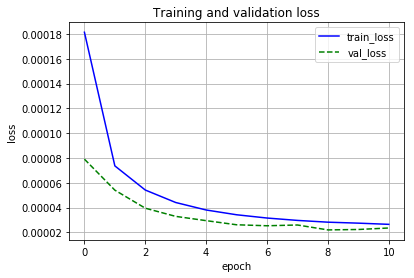

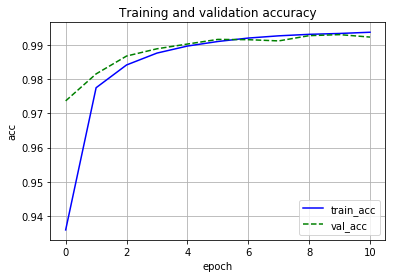


Epoch [12/10000], Loss: 0.0000256550, val_loss: 0.0000218039, val_acc: 0.9927425441



Epoch [13/10000], Loss: 0.0000253701, val_loss: 0.0000235918, val_acc: 0.9919135675



Epoch [14/10000], Loss: 0.0000247675, val_loss: 0.0000204498, val_acc: 0.9932156864
Saving the checkpoint...



Epoch [15/10000], Loss: 0.0000244109, val_loss: 0.0000209579, val_acc: 0.9933056226
Saving the checkpoint...



Epoch [16/10000], Loss: 0.0000242170, val_loss: 0.0000201133, val_acc: 0.9931531222



Epoch [17/10000], Loss: 0.0000238519, val_loss: 0.0000209426, val_acc: 0.9926174155



Epoch [18/10000], Loss: 0.0000234988, val_loss: 0.0000188375, val_acc: 0.9935793413
Saving the checkpoint...



Epoch [19/10000], Loss: 0.0000234340, val_loss: 0.0000202200, val_acc: 0.9930475449



Epoch [20/10000], Loss: 0.0000231292, val_loss: 0.0000191879, val_acc: 0.9933994690



Epoch [21/10000], Loss: 0.0000231030, val_loss: 0.0000236054, val_acc: 0.9917493362
              precision    recall  f1-score   support

           O       1.00      0.97      0.98     47091
          BS       0.54      0.92      0.68      1384
          ES       0.77      0.99      0.87      1384

   micro avg       0.97      0.97      0.97     49859
   macro avg       0.77      0.96      0.84     49859
weighted avg       0.98      0.97      0.97     49859



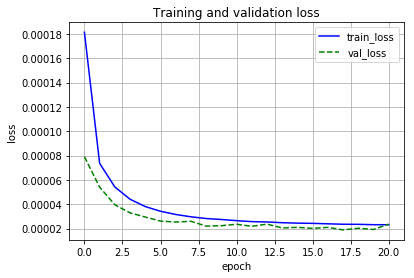

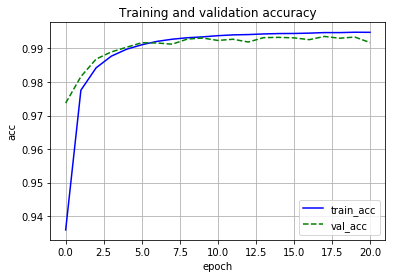


Epoch [22/10000], Loss: 0.0000226672, val_loss: 0.0000189009, val_acc: 0.9933369047



Epoch [23/10000], Loss: 0.0000225788, val_loss: 0.0000197405, val_acc: 0.9932665199



Epoch [24/10000], Loss: 0.0000222971, val_loss: 0.0000187424, val_acc: 0.9936067131
Saving the checkpoint...



Epoch [25/10000], Loss: 0.0000222255, val_loss: 0.0000204856, val_acc: 0.9932352378



Epoch [26/10000], Loss: 0.0000225251, val_loss: 0.0000183462, val_acc: 0.9936731877
Saving the checkpoint...



Epoch [27/10000], Loss: 0.0000220911, val_loss: 0.0000189298, val_acc: 0.9934972257



Epoch [28/10000], Loss: 0.0000218736, val_loss: 0.0000187230, val_acc: 0.9939390859
Saving the checkpoint...



Epoch [29/10000], Loss: 0.0000220267, val_loss: 0.0000183934, val_acc: 0.9936692774



Epoch [30/10000], Loss: 0.0000218650, val_loss: 0.0000183473, val_acc: 0.9934581230



Epoch [31/10000], Loss: 0.0000216410, val_loss: 0.0000180106, val_acc: 0.9937122904
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.69      0.90      0.78      1384
          ES       0.79      0.99      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



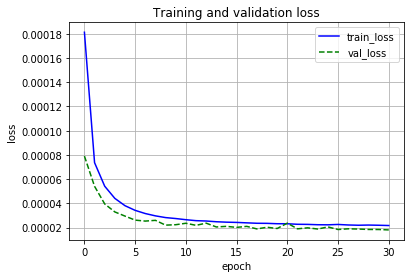

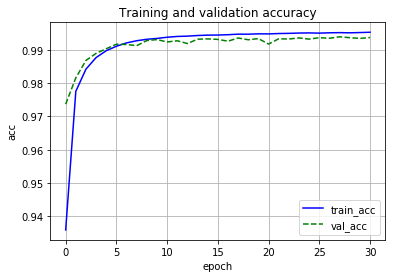


Epoch [32/10000], Loss: 0.0000216310, val_loss: 0.0000185473, val_acc: 0.9936340850



Epoch [33/10000], Loss: 0.0000215143, val_loss: 0.0000184880, val_acc: 0.9933955587



Epoch [34/10000], Loss: 0.0000215034, val_loss: 0.0000181010, val_acc: 0.9939117140



Epoch [35/10000], Loss: 0.0000214728, val_loss: 0.0000188577, val_acc: 0.9933447252



Epoch [36/10000], Loss: 0.0000212425, val_loss: 0.0000183152, val_acc: 0.9936262645



Epoch [37/10000], Loss: 0.0000211441, val_loss: 0.0000183353, val_acc: 0.9939860091
Saving the checkpoint...



Epoch [38/10000], Loss: 0.0000211730, val_loss: 0.0000182665, val_acc: 0.9936497261



Epoch [39/10000], Loss: 0.0000211966, val_loss: 0.0000175892, val_acc: 0.9938452394



Epoch [40/10000], Loss: 0.0000209598, val_loss: 0.0000191641, val_acc: 0.9934737641



Epoch [48/10000], Loss: 0.0000206490, val_loss: 0.0000180214, val_acc: 0.9939547269



Epoch [49/10000], Loss: 0.0000206816, val_loss: 0.0000204000, val_acc: 0.9927972878



Epoch [50/10000], Loss: 0.0000207552, val_loss: 0.0000174825, val_acc: 0.9939977399



Epoch [51/10000], Loss: 0.0000205741, val_loss: 0.0000179486, val_acc: 0.9937474828
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.68      0.90      0.77      1384
          ES       0.78      0.99      0.87      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



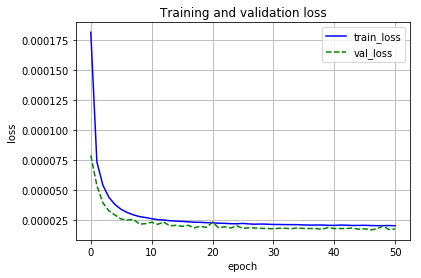

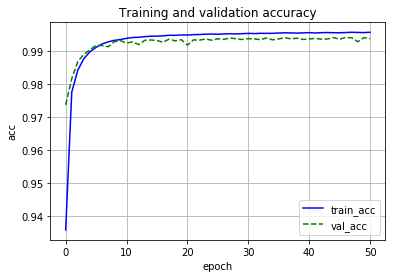


Epoch [52/10000], Loss: 0.0000205414, val_loss: 0.0000182269, val_acc: 0.9936731877



Epoch [53/10000], Loss: 0.0000205912, val_loss: 0.0000177400, val_acc: 0.9939664577



Epoch [54/10000], Loss: 0.0000204944, val_loss: 0.0000180909, val_acc: 0.9938452394



Epoch [55/10000], Loss: 0.0000205297, val_loss: 0.0000176652, val_acc: 0.9938335086



Epoch [56/10000], Loss: 0.0000205674, val_loss: 0.0000187012, val_acc: 0.9932860712



Epoch [57/10000], Loss: 0.0000205169, val_loss: 0.0000174712, val_acc: 0.9939781885


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch [88/10000], Loss: 0.0000198742, val_loss: 0.0000173397, val_acc: 0.9938569702



Epoch [89/10000], Loss: 0.0000198222, val_loss: 0.0000178319, val_acc: 0.9937162006



Epoch [90/10000], Loss: 0.0000196742, val_loss: 0.0000176576, val_acc: 0.9939742783



Epoch [91/10000], Loss: 0.0000198049, val_loss: 0.0000174872, val_acc: 0.9937044698
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.64      0.91      0.75      1384
          ES       0.79      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.81      0.96      0.87     49859
weighted avg       0.98      0.98      0.98     49859



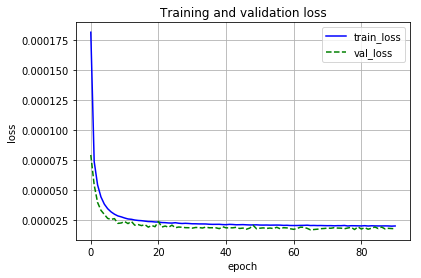

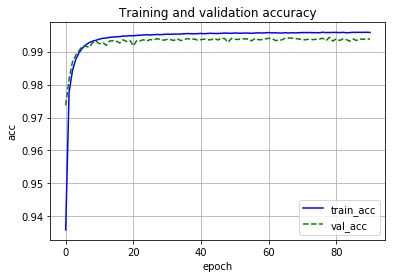


Epoch [92/10000], Loss: 0.0000197737, val_loss: 0.0000170027, val_acc: 0.9940563939



Epoch [93/10000], Loss: 0.0000196915, val_loss: 0.0000173433, val_acc: 0.9938882524



Epoch [94/10000], Loss: 0.0000197908, val_loss: 0.0000167136, val_acc: 0.9942675483



Epoch [95/10000], Loss: 0.0000196153, val_loss: 0.0000181267, val_acc: 0.9934111998



Epoch [96/10000], Loss: 0.0000196287, val_loss: 0.0000190827, val_acc: 0.9940876760



Epoch [97/10000], Loss: 0.0000196417, val_loss: 0.0000170663, val_acc: 0.9942714586



Epoch [98/10000], Loss: 0.0000197813, val_loss: 0.0000173113, val_acc: 0.9940329323



Epoch [99/10000], Loss: 0.0000199055, val_loss: 0.0000181285, val_acc: 0.9935089565



Epoch [100/10000], Loss: 0.0000194369, val_loss: 0.0000180847, val_acc: 0.9941306889



Epoch [101/10000], Loss: 0.0000196212, val_loss: 0.0000175289, val_acc: 0.9942088943
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.72      0.89      0.79      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.85      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



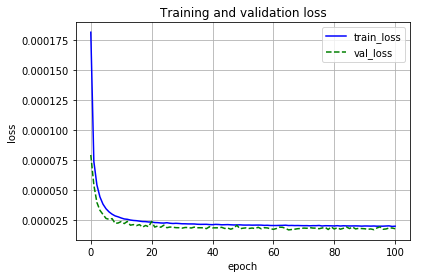

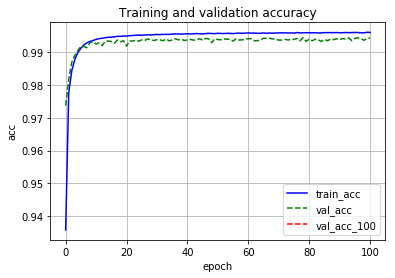

acc max step:100



Epoch [102/10000], Loss: 0.0000197536, val_loss: 0.0000175957, val_acc: 0.9936497261



Epoch [103/10000], Loss: 0.0000196666, val_loss: 0.0000170148, val_acc: 0.9942479970



Epoch [104/10000], Loss: 0.0000196611, val_loss: 0.0000198156, val_acc: 0.9929536985



Epoch [105/10000], Loss: 0.0000197688, val_loss: 0.0000172232, val_acc: 0.9939390859



Epoch [106/10000], Loss: 0.0000196292, val_loss: 0.0000167671, val_acc: 0.9942010738



Epoch [107/10000], Loss: 0.0000196693, val_loss: 0.0000208281, val_acc: 0.9927738262



Epoch [108/10000], Loss: 0.0000196800, val_loss: 0.0000173049, val_acc: 0.9938647908



Epoch [109/10000], Loss: 0.0000194181, val_loss: 0.0000177516, val_acc: 0.9940446631



Epoch [110/10000], Loss: 0.0000195904, val_loss: 0.0000174520, val_acc: 0.9939078037



Epoch [111/10000], Loss: 0.0000195167, val_loss: 0.0000193648, val_acc: 0.9931883146
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.63      0.92      0.75      1384
          ES       0.79      0.98      0.87      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.81      0.96      0.87     49859
weighted avg       0.98      0.98      0.98     49859



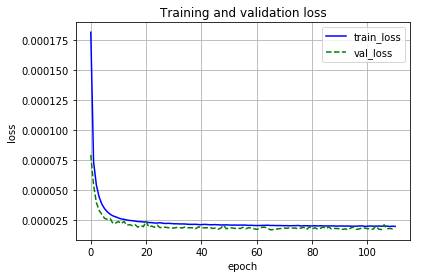

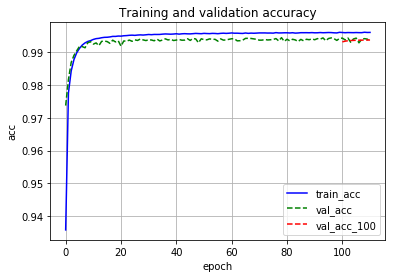

acc max step:110



Epoch [112/10000], Loss: 0.0000194773, val_loss: 0.0000182599, val_acc: 0.9935285078



Epoch [113/10000], Loss: 0.0000195242, val_loss: 0.0000169020, val_acc: 0.9939820988



Epoch [114/10000], Loss: 0.0000196063, val_loss: 0.0000190389, val_acc: 0.9932430583



Epoch [115/10000], Loss: 0.0000196084, val_loss: 0.0000208436, val_acc: 0.9926682490



Epoch [116/10000], Loss: 0.0000196414, val_loss: 0.0000178233, val_acc: 0.9936653672



Epoch [117/10000], Loss: 0.0000196284, val_loss: 0.0000168491, val_acc: 0.9941971635



Epoch [118/10000], Loss: 0.0000195707, val_loss: 0.0000182206, val_acc: 0.9935011359



Epoch [119/10000], Loss: 0.0000197361, val_loss: 0.0000166972, val_acc: 0.9942910099



Epoch [120/10000], Loss: 0.0000196936, val_loss: 0.0000172166, val_acc: 0.9937748546



Epoch [121/10000], Loss: 0.0000194571, val_loss: 0.0000177813, val_acc: 0.9941776122
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     47091
          BS       0.75      0.88      0.81      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.86      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



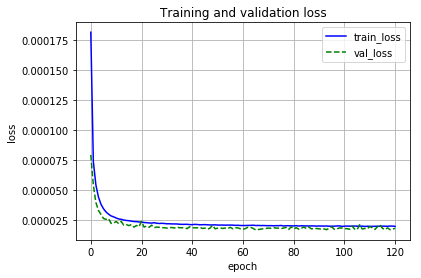

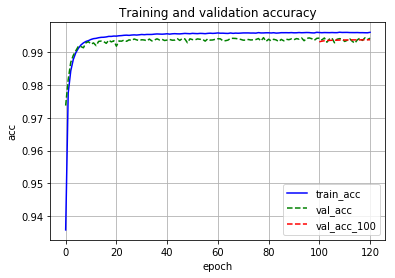

acc max step:120



Epoch [122/10000], Loss: 0.0000196102, val_loss: 0.0000183059, val_acc: 0.9934542127



Epoch [123/10000], Loss: 0.0000193653, val_loss: 0.0000182157, val_acc: 0.9940368425



Epoch [124/10000], Loss: 0.0000193571, val_loss: 0.0000164639, val_acc: 0.9943613947
Saving the checkpoint...



Epoch [125/10000], Loss: 0.0000194562, val_loss: 0.0000169179, val_acc: 0.9940407528



Epoch [126/10000], Loss: 0.0000193637, val_loss: 0.0000169345, val_acc: 0.9940798555



Epoch [127/10000], Loss: 0.0000194214, val_loss: 0.0000179505, val_acc: 0.9935285078



Epoch [128/10000], Loss: 0.0000194179, val_loss: 0.0000205565, val_acc: 0.9929341472



Epoch [129/10000], Loss: 0.0000195096, val_loss: 0.0000172849, val_acc: 0.9937474828



Epoch [130/10000], Loss: 0.0000194184, val_loss: 0.0000167788, val_acc: 0.9940407528



Epoch [131/10000], Loss: 0.0000195817, val_loss: 0.0000170427, val_acc: 0.9944591514
Saving the checkpoint...
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     47091
          BS       0.75      0.89      0.82      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.86      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



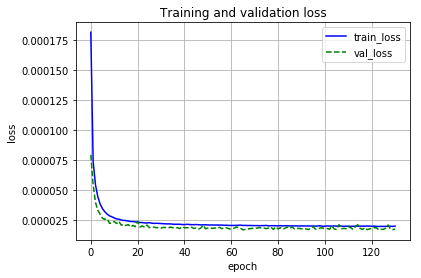

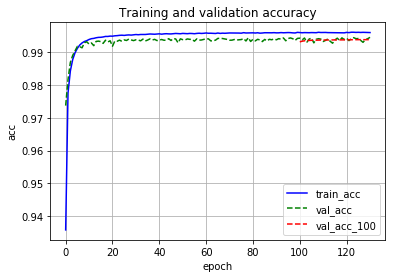

acc max step:127



Epoch [132/10000], Loss: 0.0000192711, val_loss: 0.0000174777, val_acc: 0.9936849185



Epoch [133/10000], Loss: 0.0000194425, val_loss: 0.0000172061, val_acc: 0.9940876760



Epoch [134/10000], Loss: 0.0000193983, val_loss: 0.0000191943, val_acc: 0.9936223542



Epoch [135/10000], Loss: 0.0000192989, val_loss: 0.0000167760, val_acc: 0.9940642144



Epoch [136/10000], Loss: 0.0000192754, val_loss: 0.0000187343, val_acc: 0.9938765216



Epoch [137/10000], Loss: 0.0000193856, val_loss: 0.0000168361, val_acc: 0.9942049840



Epoch [138/10000], Loss: 0.0000194532, val_loss: 0.0000165676, val_acc: 0.9942010738



Epoch [139/10000], Loss: 0.0000192192, val_loss: 0.0000171145, val_acc: 0.9937983162



Epoch [140/10000], Loss: 0.0000193574, val_loss: 0.0000170352, val_acc: 0.9941189581



Epoch [141/10000], Loss: 0.0000193478, val_loss: 0.0000172308, val_acc: 0.9939038935
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.68      0.90      0.78      1384
          ES       0.81      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



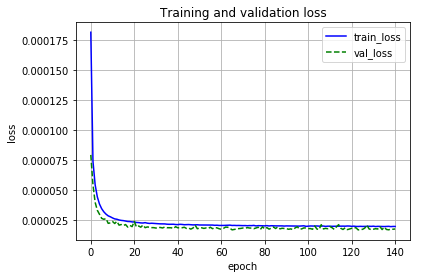

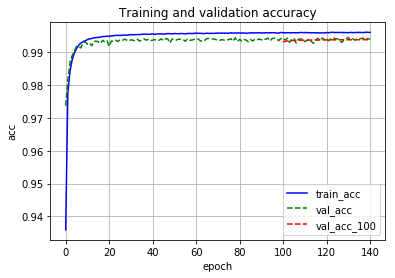

acc max step:140



Epoch [142/10000], Loss: 0.0000193804, val_loss: 0.0000169057, val_acc: 0.9940251117



Epoch [143/10000], Loss: 0.0000193463, val_loss: 0.0000166775, val_acc: 0.9940251117



Epoch [144/10000], Loss: 0.0000194651, val_loss: 0.0000178944, val_acc: 0.9937983162



Epoch [145/10000], Loss: 0.0000193394, val_loss: 0.0000176843, val_acc: 0.9936379953



Epoch [146/10000], Loss: 0.0000192730, val_loss: 0.0000173000, val_acc: 0.9940524836



Epoch [147/10000], Loss: 0.0000193115, val_loss: 0.0000174723, val_acc: 0.9936340850



Epoch [148/10000], Loss: 0.0000192446, val_loss: 0.0000171575, val_acc: 0.9939351756



Epoch [149/10000], Loss: 0.0000192512, val_loss: 0.0000170911, val_acc: 0.9938335086



Epoch [150/10000], Loss: 0.0000192906, val_loss: 0.0000168640, val_acc: 0.9941150479



Epoch [151/10000], Loss: 0.0000193318, val_loss: 0.0000184575, val_acc: 0.9933916485
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.65      0.92      0.76      1384
          ES       0.78      0.99      0.87      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.81      0.96      0.87     49859
weighted avg       0.98      0.98      0.98     49859



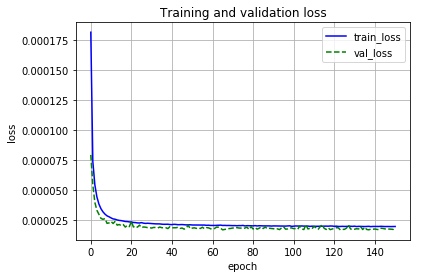

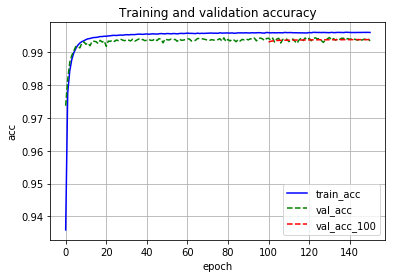

acc max step:150



Epoch [152/10000], Loss: 0.0000192804, val_loss: 0.0000170189, val_acc: 0.9944239590



Epoch [153/10000], Loss: 0.0000193347, val_loss: 0.0000168860, val_acc: 0.9943105612



Epoch [154/10000], Loss: 0.0000193038, val_loss: 0.0000182314, val_acc: 0.9934776743



Epoch [155/10000], Loss: 0.0000194535, val_loss: 0.0000169976, val_acc: 0.9938726113



Epoch [156/10000], Loss: 0.0000191619, val_loss: 0.0000177607, val_acc: 0.9936497261



Epoch [157/10000], Loss: 0.0000194850, val_loss: 0.0000178560, val_acc: 0.9936028029



Epoch [158/10000], Loss: 0.0000192631, val_loss: 0.0000167221, val_acc: 0.9941697916



Epoch [159/10000], Loss: 0.0000195498, val_loss: 0.0000174240, val_acc: 0.9940212015



Epoch [160/10000], Loss: 0.0000192507, val_loss: 0.0000169233, val_acc: 0.9940485733



Epoch [161/10000], Loss: 0.0000193077, val_loss: 0.0000172663, val_acc: 0.9940251117
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.70      0.89      0.78      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



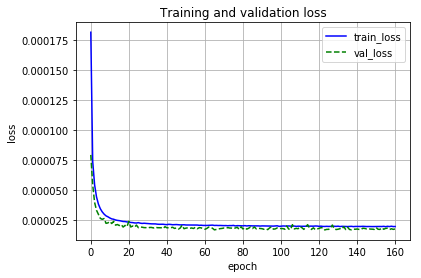

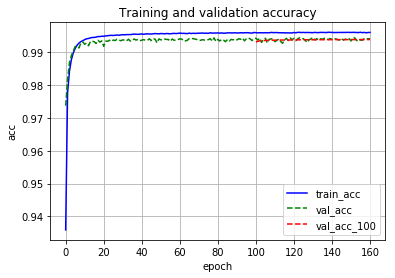

acc max step:160



Epoch [162/10000], Loss: 0.0000192529, val_loss: 0.0000177664, val_acc: 0.9934933154



Epoch [163/10000], Loss: 0.0000193930, val_loss: 0.0000173735, val_acc: 0.9941306889



Epoch [164/10000], Loss: 0.0000192565, val_loss: 0.0000175051, val_acc: 0.9937670341



Epoch [165/10000], Loss: 0.0000193040, val_loss: 0.0000168353, val_acc: 0.9943027407



Epoch [166/10000], Loss: 0.0000192807, val_loss: 0.0000165320, val_acc: 0.9944122282



Epoch [167/10000], Loss: 0.0000191542, val_loss: 0.0000169367, val_acc: 0.9942010738



Epoch [168/10000], Loss: 0.0000191303, val_loss: 0.0000168056, val_acc: 0.9940329323



Epoch [169/10000], Loss: 0.0000191059, val_loss: 0.0000184111, val_acc: 0.9934072895



Epoch [170/10000], Loss: 0.0000193236, val_loss: 0.0000212342, val_acc: 0.9923632482



Epoch [171/10000], Loss: 0.0000191513, val_loss: 0.0000167988, val_acc: 0.9939781885
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.67      0.90      0.77      1384
          ES       0.82      0.99      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



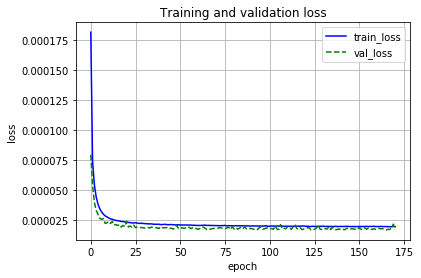

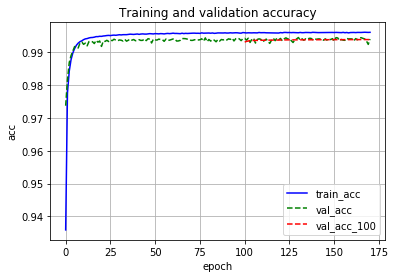

acc max step:167



Epoch [172/10000], Loss: 0.0000191601, val_loss: 0.0000164353, val_acc: 0.9942128046



Epoch [173/10000], Loss: 0.0000191116, val_loss: 0.0000165418, val_acc: 0.9940368425



Epoch [174/10000], Loss: 0.0000193096, val_loss: 0.0000168579, val_acc: 0.9944747925
Saving the checkpoint...



Epoch [175/10000], Loss: 0.0000193595, val_loss: 0.0000186519, val_acc: 0.9933877382



Epoch [176/10000], Loss: 0.0000192723, val_loss: 0.0000166472, val_acc: 0.9941658814



Epoch [177/10000], Loss: 0.0000193292, val_loss: 0.0000166457, val_acc: 0.9943613947



Epoch [178/10000], Loss: 0.0000191139, val_loss: 0.0000180973, val_acc: 0.9933251739



Epoch [179/10000], Loss: 0.0000192059, val_loss: 0.0000175642, val_acc: 0.9940994068



Epoch [180/10000], Loss: 0.0000192334, val_loss: 0.0000167932, val_acc: 0.9942440867



Epoch [181/10000], Loss: 0.0000191665, val_loss: 0.0000173953, val_acc: 0.9940876760
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.70      0.89      0.78      1384
          ES       0.81      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



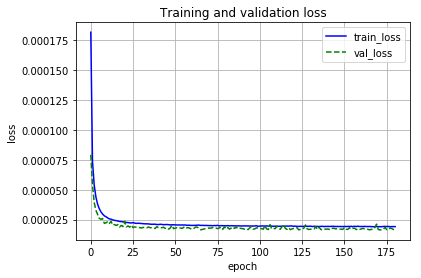

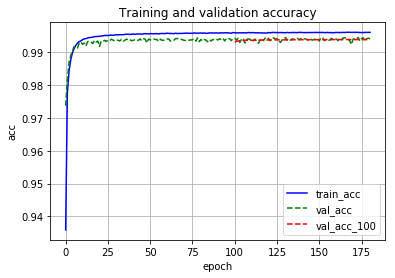

acc max step:180



Epoch [182/10000], Loss: 0.0000191328, val_loss: 0.0000172293, val_acc: 0.9936770980



Epoch [183/10000], Loss: 0.0000190817, val_loss: 0.0000166705, val_acc: 0.9939977399



Epoch [184/10000], Loss: 0.0000191190, val_loss: 0.0000174968, val_acc: 0.9939038935



Epoch [185/10000], Loss: 0.0000192658, val_loss: 0.0000172747, val_acc: 0.9938608805



Epoch [186/10000], Loss: 0.0000192386, val_loss: 0.0000175929, val_acc: 0.9936810082



Epoch [187/10000], Loss: 0.0000192010, val_loss: 0.0000178598, val_acc: 0.9935910721



Epoch [188/10000], Loss: 0.0000190331, val_loss: 0.0000173497, val_acc: 0.9943027407



Epoch [189/10000], Loss: 0.0000191916, val_loss: 0.0000170189, val_acc: 0.9942206251



Epoch [190/10000], Loss: 0.0000191126, val_loss: 0.0000176722, val_acc: 0.9935558797



Epoch [191/10000], Loss: 0.0000193579, val_loss: 0.0000165748, val_acc: 0.9942323559
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.71      0.89      0.79      1384
          ES       0.82      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



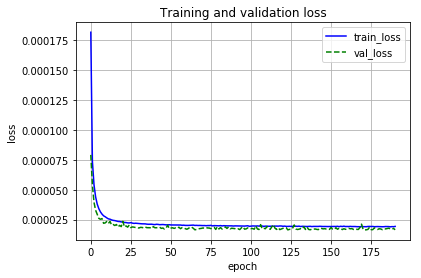

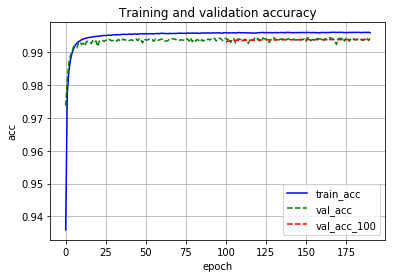

acc max step:189



Epoch [192/10000], Loss: 0.0000191986, val_loss: 0.0000177278, val_acc: 0.9936184439



Epoch [193/10000], Loss: 0.0000191669, val_loss: 0.0000170796, val_acc: 0.9939038935



Epoch [194/10000], Loss: 0.0000192688, val_loss: 0.0000175375, val_acc: 0.9937553033



Epoch [195/10000], Loss: 0.0000191138, val_loss: 0.0000169144, val_acc: 0.9940251117



Epoch [196/10000], Loss: 0.0000191156, val_loss: 0.0000161322, val_acc: 0.9941893430



Epoch [197/10000], Loss: 0.0000191791, val_loss: 0.0000191131, val_acc: 0.9930670963



Epoch [198/10000], Loss: 0.0000192084, val_loss: 0.0000180198, val_acc: 0.9934933154



Epoch [199/10000], Loss: 0.0000190326, val_loss: 0.0000168905, val_acc: 0.9944552411



Epoch [200/10000], Loss: 0.0000192059, val_loss: 0.0000169116, val_acc: 0.9940016501



Epoch [201/10000], Loss: 0.0000190804, val_loss: 0.0000160620, val_acc: 0.9942088943
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.71      0.90      0.79      1384
          ES       0.80      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



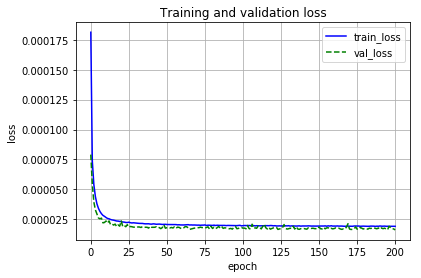

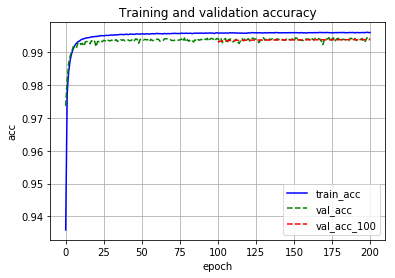

acc max step:191



Epoch [202/10000], Loss: 0.0000191557, val_loss: 0.0000171532, val_acc: 0.9942440867



Epoch [203/10000], Loss: 0.0000191554, val_loss: 0.0000182185, val_acc: 0.9934933154



Epoch [204/10000], Loss: 0.0000193058, val_loss: 0.0000193123, val_acc: 0.9933603663



Epoch [205/10000], Loss: 0.0000192222, val_loss: 0.0000180934, val_acc: 0.9934698538



Epoch [206/10000], Loss: 0.0000191186, val_loss: 0.0000164686, val_acc: 0.9941658814



Epoch [207/10000], Loss: 0.0000190584, val_loss: 0.0000166410, val_acc: 0.9941502403



Epoch [208/10000], Loss: 0.0000189643, val_loss: 0.0000173245, val_acc: 0.9941345992



Epoch [209/10000], Loss: 0.0000190685, val_loss: 0.0000176119, val_acc: 0.9935441489



Epoch [210/10000], Loss: 0.0000191666, val_loss: 0.0000187079, val_acc: 0.9940954965



Epoch [211/10000], Loss: 0.0000190731, val_loss: 0.0000167364, val_acc: 0.9940720349
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.67      0.91      0.77      1384
          ES       0.80      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



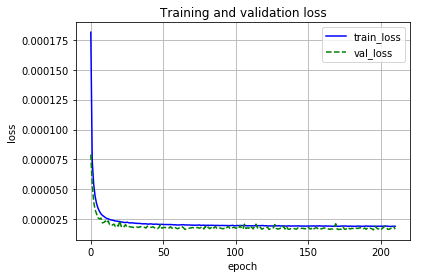

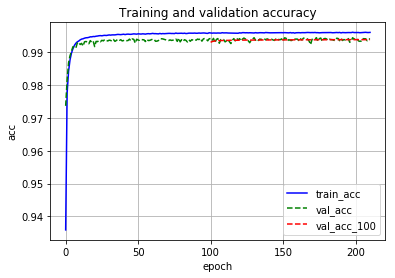

acc max step:208



Epoch [212/10000], Loss: 0.0000190556, val_loss: 0.0000166866, val_acc: 0.9940603041



Epoch [213/10000], Loss: 0.0000191248, val_loss: 0.0000164525, val_acc: 0.9941463300



Epoch [214/10000], Loss: 0.0000189972, val_loss: 0.0000196922, val_acc: 0.9929810704



Epoch [215/10000], Loss: 0.0000192128, val_loss: 0.0000176931, val_acc: 0.9943144715



Epoch [216/10000], Loss: 0.0000190236, val_loss: 0.0000171161, val_acc: 0.9940485733



Epoch [217/10000], Loss: 0.0000191341, val_loss: 0.0000183260, val_acc: 0.9940994068



Epoch [218/10000], Loss: 0.0000191613, val_loss: 0.0000168470, val_acc: 0.9941072273



Epoch [219/10000], Loss: 0.0000191894, val_loss: 0.0000165269, val_acc: 0.9941111376



Epoch [220/10000], Loss: 0.0000190469, val_loss: 0.0000176994, val_acc: 0.9936849185



Epoch [221/10000], Loss: 0.0000190952, val_loss: 0.0000185288, val_acc: 0.9942284456
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     47091
          BS       0.77      0.86      0.81      1384
          ES       0.81      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.86      0.94      0.90     49859
weighted avg       0.98      0.98      0.98     49859



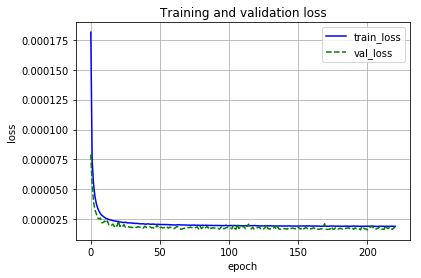

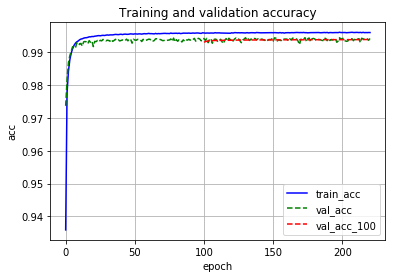

acc max step:218



Epoch [222/10000], Loss: 0.0000190752, val_loss: 0.0000163497, val_acc: 0.9941893430



Epoch [223/10000], Loss: 0.0000190334, val_loss: 0.0000172129, val_acc: 0.9939156243



Epoch [224/10000], Loss: 0.0000190357, val_loss: 0.0000185621, val_acc: 0.9934894051



Epoch [225/10000], Loss: 0.0000191491, val_loss: 0.0000180585, val_acc: 0.9941737019



Epoch [226/10000], Loss: 0.0000191040, val_loss: 0.0000176749, val_acc: 0.9936888288



Epoch [227/10000], Loss: 0.0000191343, val_loss: 0.0000167483, val_acc: 0.9940290220



Epoch [228/10000], Loss: 0.0000189840, val_loss: 0.0000169801, val_acc: 0.9944239590



Epoch [229/10000], Loss: 0.0000190296, val_loss: 0.0000198915, val_acc: 0.9929615191



Epoch [230/10000], Loss: 0.0000190166, val_loss: 0.0000164209, val_acc: 0.9946194723
Saving the checkpoint...



Epoch [231/10000], Loss: 0.0000189633, val_loss: 0.0000165443, val_acc: 0.9941306889
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.69      0.91      0.78      1384
          ES       0.78      0.99      0.87      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



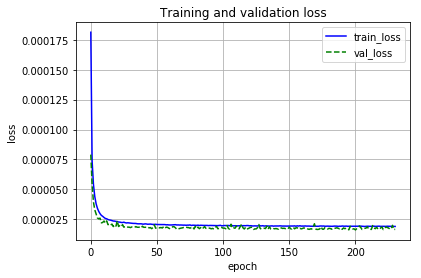

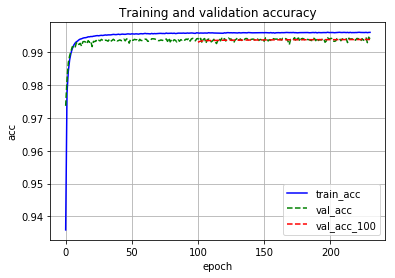

acc max step:228



Epoch [232/10000], Loss: 0.0000192354, val_loss: 0.0000169800, val_acc: 0.9939781885



Epoch [233/10000], Loss: 0.0000190350, val_loss: 0.0000164503, val_acc: 0.9942479970



Epoch [234/10000], Loss: 0.0000191492, val_loss: 0.0000181579, val_acc: 0.9933408150



Epoch [235/10000], Loss: 0.0000189244, val_loss: 0.0000159855, val_acc: 0.9942323559



Epoch [236/10000], Loss: 0.0000189895, val_loss: 0.0000165806, val_acc: 0.9940290220



Epoch [237/10000], Loss: 0.0000191482, val_loss: 0.0000166919, val_acc: 0.9941345992



Epoch [238/10000], Loss: 0.0000191838, val_loss: 0.0000175309, val_acc: 0.9942323559



Epoch [239/10000], Loss: 0.0000189865, val_loss: 0.0000176425, val_acc: 0.9941072273



Epoch [240/10000], Loss: 0.0000188914, val_loss: 0.0000166362, val_acc: 0.9943262023



Epoch [241/10000], Loss: 0.0000190376, val_loss: 0.0000202386, val_acc: 0.9925196589
              precision    recall  f1-score   support

           O       1.00      0.97      0.99     47091
          BS       0.59      0.93      0.72      1384
          ES       0.78      0.99      0.87      1384

   micro avg       0.97      0.97      0.97     49859
   macro avg       0.79      0.96      0.86     49859
weighted avg       0.98      0.97      0.97     49859



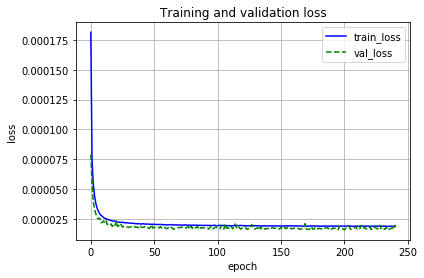

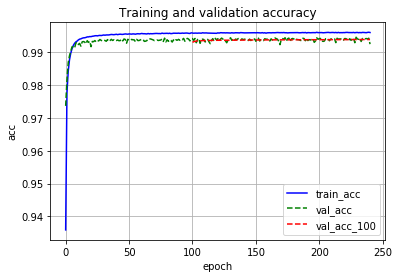

acc max step:240



Epoch [242/10000], Loss: 0.0000190629, val_loss: 0.0000188045, val_acc: 0.9932978020



Epoch [243/10000], Loss: 0.0000191720, val_loss: 0.0000171809, val_acc: 0.9939860091



Epoch [244/10000], Loss: 0.0000189951, val_loss: 0.0000168242, val_acc: 0.9939860091



Epoch [245/10000], Loss: 0.0000190387, val_loss: 0.0000167974, val_acc: 0.9940876760



Epoch [246/10000], Loss: 0.0000192432, val_loss: 0.0000169440, val_acc: 0.9940681247



Epoch [247/10000], Loss: 0.0000190545, val_loss: 0.0000176673, val_acc: 0.9941424198



Epoch [248/10000], Loss: 0.0000190104, val_loss: 0.0000172846, val_acc: 0.9940329323



Epoch [249/10000], Loss: 0.0000189847, val_loss: 0.0000179262, val_acc: 0.9941932532



Epoch [250/10000], Loss: 0.0000190747, val_loss: 0.0000165452, val_acc: 0.9941267787



Epoch [251/10000], Loss: 0.0000189706, val_loss: 0.0000165770, val_acc: 0.9939195345
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.69      0.91      0.78      1384
          ES       0.80      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



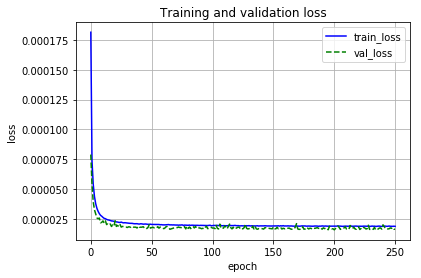

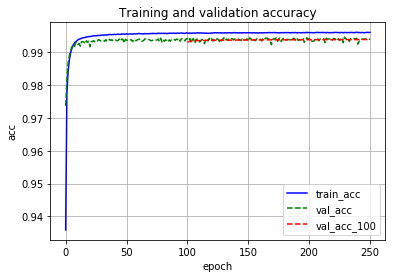

acc max step:240



Epoch [252/10000], Loss: 0.0000191529, val_loss: 0.0000173184, val_acc: 0.9942558175



Epoch [253/10000], Loss: 0.0000189902, val_loss: 0.0000182945, val_acc: 0.9933290842



Epoch [254/10000], Loss: 0.0000192556, val_loss: 0.0000204527, val_acc: 0.9926643388



Epoch [255/10000], Loss: 0.0000189561, val_loss: 0.0000215057, val_acc: 0.9922224786



Epoch [256/10000], Loss: 0.0000190574, val_loss: 0.0000171167, val_acc: 0.9939625475



Epoch [257/10000], Loss: 0.0000189221, val_loss: 0.0000167788, val_acc: 0.9942323559



Epoch [258/10000], Loss: 0.0000189573, val_loss: 0.0000164471, val_acc: 0.9942675483



Epoch [259/10000], Loss: 0.0000190104, val_loss: 0.0000170707, val_acc: 0.9939195345



Epoch [260/10000], Loss: 0.0000190546, val_loss: 0.0000172499, val_acc: 0.9938295984



Epoch [261/10000], Loss: 0.0000190266, val_loss: 0.0000167316, val_acc: 0.9940446631
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.70      0.90      0.79      1384
          ES       0.80      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



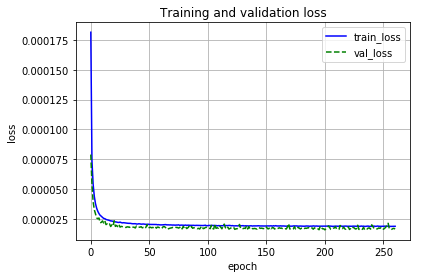

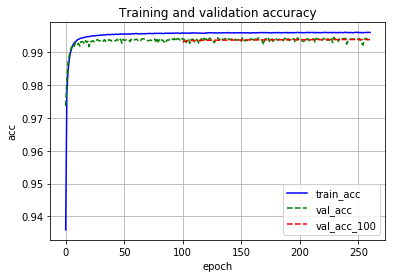

acc max step:251



Epoch [262/10000], Loss: 0.0000189595, val_loss: 0.0000172267, val_acc: 0.9937592136



Epoch [263/10000], Loss: 0.0000189446, val_loss: 0.0000175072, val_acc: 0.9944708822



Epoch [264/10000], Loss: 0.0000190562, val_loss: 0.0000164620, val_acc: 0.9943262023



Epoch [265/10000], Loss: 0.0000189520, val_loss: 0.0000166928, val_acc: 0.9941619711



Epoch [266/10000], Loss: 0.0000191869, val_loss: 0.0000176456, val_acc: 0.9936810082



Epoch [267/10000], Loss: 0.0000190411, val_loss: 0.0000185972, val_acc: 0.9941815224



Epoch [268/10000], Loss: 0.0000190207, val_loss: 0.0000162000, val_acc: 0.9943535742



Epoch [269/10000], Loss: 0.0000189909, val_loss: 0.0000169528, val_acc: 0.9941228684



Epoch [270/10000], Loss: 0.0000189249, val_loss: 0.0000181482, val_acc: 0.9933681868



Epoch [271/10000], Loss: 0.0000190994, val_loss: 0.0000159250, val_acc: 0.9943770358
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.72      0.91      0.80      1384
          ES       0.82      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.85      0.96      0.90     49859
weighted avg       0.98      0.98      0.98     49859



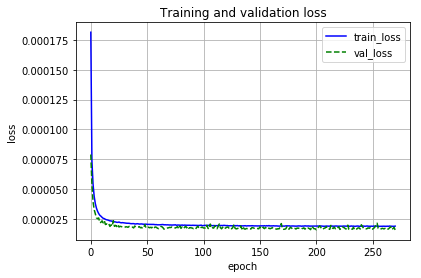

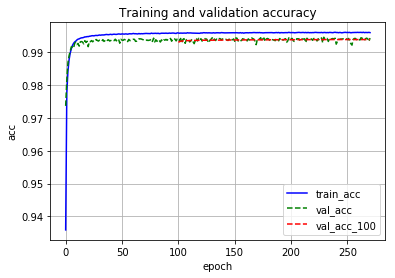

acc max step:251



Epoch [272/10000], Loss: 0.0000189548, val_loss: 0.0000171279, val_acc: 0.9942714586



Epoch [273/10000], Loss: 0.0000190644, val_loss: 0.0000179812, val_acc: 0.9935871618



Epoch [274/10000], Loss: 0.0000189943, val_loss: 0.0000176684, val_acc: 0.9937474828



Epoch [275/10000], Loss: 0.0000191368, val_loss: 0.0000172028, val_acc: 0.9939508167



Epoch [276/10000], Loss: 0.0000189945, val_loss: 0.0000161604, val_acc: 0.9942910099



Epoch [277/10000], Loss: 0.0000189475, val_loss: 0.0000168199, val_acc: 0.9939938296



Epoch [278/10000], Loss: 0.0000190031, val_loss: 0.0000162341, val_acc: 0.9940876760



Epoch [279/10000], Loss: 0.0000189859, val_loss: 0.0000167574, val_acc: 0.9941345992



Epoch [280/10000], Loss: 0.0000191036, val_loss: 0.0000163954, val_acc: 0.9942440867



Epoch [281/10000], Loss: 0.0000189460, val_loss: 0.0000177895, val_acc: 0.9936888288
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.66      0.91      0.76      1384
          ES       0.85      0.98      0.91      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



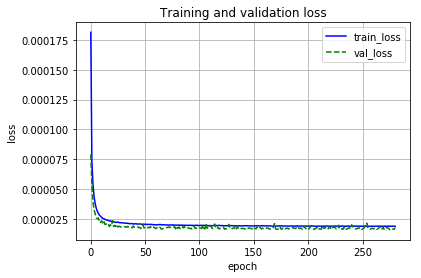

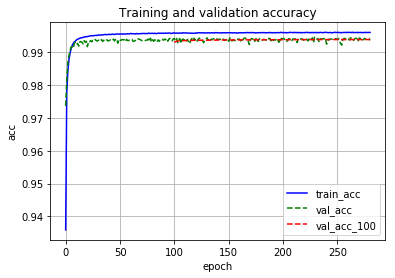

acc max step:251



Epoch [282/10000], Loss: 0.0000190163, val_loss: 0.0000173390, val_acc: 0.9936536364



Epoch [283/10000], Loss: 0.0000189244, val_loss: 0.0000171560, val_acc: 0.9936692774



Epoch [284/10000], Loss: 0.0000189505, val_loss: 0.0000173133, val_acc: 0.9940563939



Epoch [285/10000], Loss: 0.0000191030, val_loss: 0.0000164188, val_acc: 0.9941228684



Epoch [286/10000], Loss: 0.0000189038, val_loss: 0.0000167216, val_acc: 0.9942831894



Epoch [287/10000], Loss: 0.0000189608, val_loss: 0.0000170244, val_acc: 0.9937904957



Epoch [288/10000], Loss: 0.0000188623, val_loss: 0.0000165285, val_acc: 0.9942088943



Epoch [289/10000], Loss: 0.0000189214, val_loss: 0.0000193831, val_acc: 0.9930084423



Epoch [290/10000], Loss: 0.0000189385, val_loss: 0.0000172029, val_acc: 0.9941502403



Epoch [291/10000], Loss: 0.0000189196, val_loss: 0.0000167398, val_acc: 0.9942870996
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.72      0.89      0.80      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.85      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



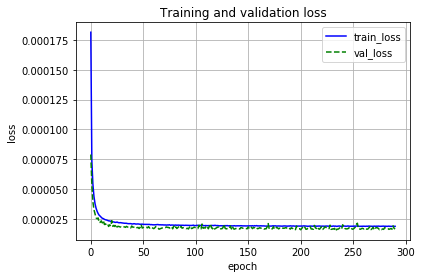

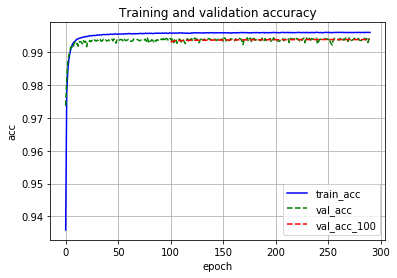

acc max step:287



Epoch [292/10000], Loss: 0.0000190142, val_loss: 0.0000164462, val_acc: 0.9941033171



Epoch [293/10000], Loss: 0.0000190752, val_loss: 0.0000176150, val_acc: 0.9937044698



Epoch [294/10000], Loss: 0.0000188708, val_loss: 0.0000163045, val_acc: 0.9944787027



Epoch [295/10000], Loss: 0.0000188816, val_loss: 0.0000173622, val_acc: 0.9939429961



Epoch [296/10000], Loss: 0.0000190499, val_loss: 0.0000160935, val_acc: 0.9942831894



Epoch [297/10000], Loss: 0.0000189073, val_loss: 0.0000169424, val_acc: 0.9939469064



Epoch [298/10000], Loss: 0.0000189072, val_loss: 0.0000173114, val_acc: 0.9937865854



Epoch [299/10000], Loss: 0.0000190069, val_loss: 0.0000167193, val_acc: 0.9942088943



Epoch [300/10000], Loss: 0.0000189270, val_loss: 0.0000170207, val_acc: 0.9939977399



Epoch [301/10000], Loss: 0.0000189759, val_loss: 0.0000169794, val_acc: 0.9944278693
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.74      0.87      0.80      1384
          ES       0.82      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.85      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



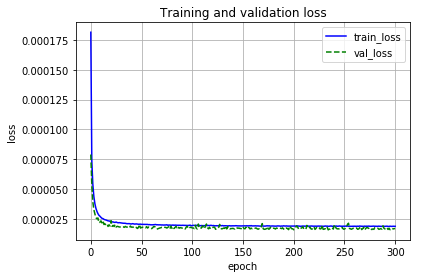

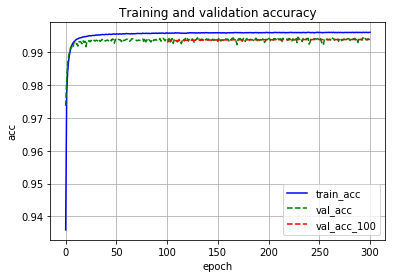

acc max step:298



Epoch [302/10000], Loss: 0.0000188045, val_loss: 0.0000170122, val_acc: 0.9938452394



Epoch [303/10000], Loss: 0.0000188655, val_loss: 0.0000187868, val_acc: 0.9932156864



Epoch [304/10000], Loss: 0.0000190096, val_loss: 0.0000170466, val_acc: 0.9940603041



Epoch [305/10000], Loss: 0.0000190678, val_loss: 0.0000166731, val_acc: 0.9942323559



Epoch [306/10000], Loss: 0.0000188254, val_loss: 0.0000168670, val_acc: 0.9940485733



Epoch [307/10000], Loss: 0.0000190554, val_loss: 0.0000163069, val_acc: 0.9942870996



Epoch [308/10000], Loss: 0.0000189415, val_loss: 0.0000170889, val_acc: 0.9936810082



Epoch [309/10000], Loss: 0.0000188614, val_loss: 0.0000167122, val_acc: 0.9939703680



Epoch [310/10000], Loss: 0.0000190016, val_loss: 0.0000163286, val_acc: 0.9943613947



Epoch [311/10000], Loss: 0.0000191297, val_loss: 0.0000163856, val_acc: 0.9942206251
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.73      0.90      0.81      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.85      0.96      0.90     49859
weighted avg       0.98      0.98      0.98     49859



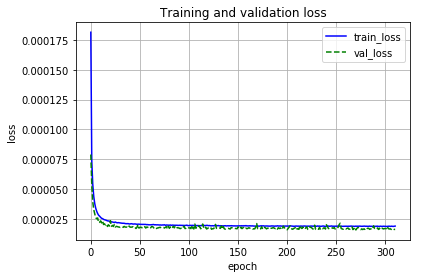

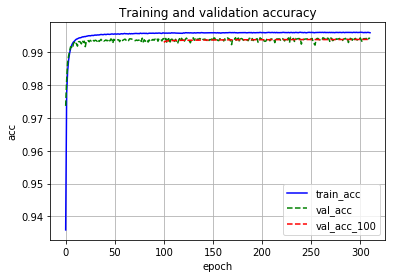

acc max step:310



Epoch [312/10000], Loss: 0.0000189145, val_loss: 0.0000194846, val_acc: 0.9929497883



Epoch [313/10000], Loss: 0.0000188123, val_loss: 0.0000169788, val_acc: 0.9938765216



Epoch [314/10000], Loss: 0.0000188327, val_loss: 0.0000167213, val_acc: 0.9940563939



Epoch [315/10000], Loss: 0.0000189123, val_loss: 0.0000167146, val_acc: 0.9943535742



Epoch [316/10000], Loss: 0.0000189938, val_loss: 0.0000178366, val_acc: 0.9936067131



Epoch [317/10000], Loss: 0.0000189133, val_loss: 0.0000169643, val_acc: 0.9937787649



Epoch [318/10000], Loss: 0.0000189184, val_loss: 0.0000171741, val_acc: 0.9939312653



Epoch [319/10000], Loss: 0.0000189496, val_loss: 0.0000175887, val_acc: 0.9939078037



Epoch [320/10000], Loss: 0.0000187910, val_loss: 0.0000172674, val_acc: 0.9940681247



Epoch [321/10000], Loss: 0.0000190453, val_loss: 0.0000163379, val_acc: 0.9943027407
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.73      0.91      0.81      1384
          ES       0.79      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



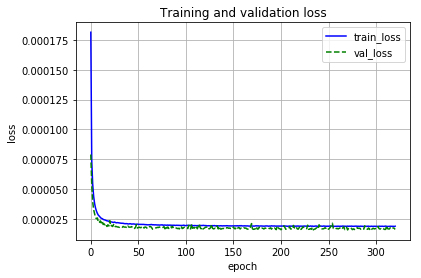

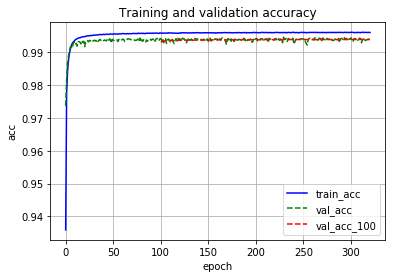

acc max step:311



Epoch [322/10000], Loss: 0.0000189138, val_loss: 0.0000163724, val_acc: 0.9942519072



Epoch [323/10000], Loss: 0.0000189083, val_loss: 0.0000167373, val_acc: 0.9940563939



Epoch [324/10000], Loss: 0.0000188677, val_loss: 0.0000160841, val_acc: 0.9942088943



Epoch [325/10000], Loss: 0.0000190815, val_loss: 0.0000174853, val_acc: 0.9939899193



Epoch [326/10000], Loss: 0.0000189559, val_loss: 0.0000171195, val_acc: 0.9941502403



Epoch [327/10000], Loss: 0.0000188370, val_loss: 0.0000171368, val_acc: 0.9939117140



Epoch [328/10000], Loss: 0.0000189393, val_loss: 0.0000162587, val_acc: 0.9942949202



Epoch [329/10000], Loss: 0.0000188845, val_loss: 0.0000161574, val_acc: 0.9941932532



Epoch [330/10000], Loss: 0.0000190891, val_loss: 0.0000173546, val_acc: 0.9943496639



Epoch [331/10000], Loss: 0.0000189514, val_loss: 0.0000181596, val_acc: 0.9934385717
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.63      0.92      0.75      1384
          ES       0.80      0.99      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.81      0.96      0.87     49859
weighted avg       0.98      0.98      0.98     49859



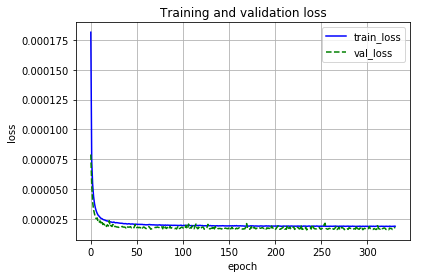

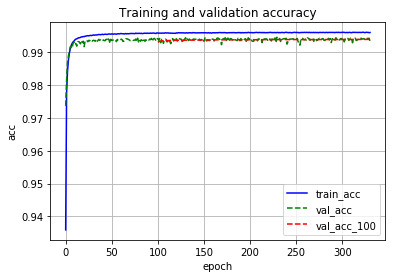

acc max step:329



Epoch [332/10000], Loss: 0.0000188640, val_loss: 0.0000169716, val_acc: 0.9937513930



Epoch [333/10000], Loss: 0.0000190099, val_loss: 0.0000180371, val_acc: 0.9934815846



Epoch [334/10000], Loss: 0.0000188643, val_loss: 0.0000166256, val_acc: 0.9940876760



Epoch [335/10000], Loss: 0.0000188263, val_loss: 0.0000179223, val_acc: 0.9940251117



Epoch [336/10000], Loss: 0.0000189126, val_loss: 0.0000166711, val_acc: 0.9940524836



Epoch [337/10000], Loss: 0.0000189880, val_loss: 0.0000176899, val_acc: 0.9935832515



Epoch [338/10000], Loss: 0.0000190275, val_loss: 0.0000165203, val_acc: 0.9943965871



Epoch [339/10000], Loss: 0.0000188945, val_loss: 0.0000173127, val_acc: 0.9938569702



Epoch [340/10000], Loss: 0.0000188343, val_loss: 0.0000161313, val_acc: 0.9942128046



Epoch [341/10000], Loss: 0.0000189144, val_loss: 0.0000174080, val_acc: 0.9938256881
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.64      0.91      0.75      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



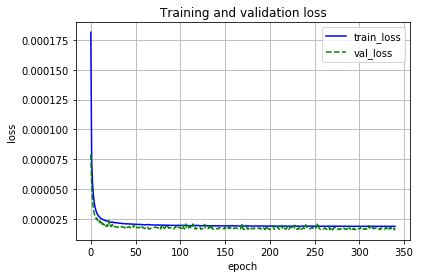

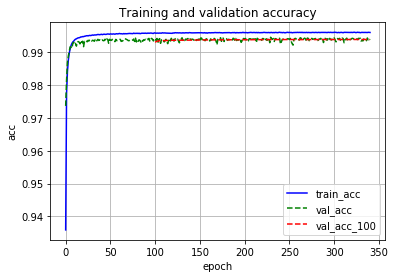

acc max step:329



Epoch [342/10000], Loss: 0.0000187933, val_loss: 0.0000167627, val_acc: 0.9945060746



Epoch [343/10000], Loss: 0.0000188341, val_loss: 0.0000175395, val_acc: 0.9936927390



Epoch [344/10000], Loss: 0.0000187640, val_loss: 0.0000168819, val_acc: 0.9938413292



Epoch [345/10000], Loss: 0.0000188853, val_loss: 0.0000180463, val_acc: 0.9935441489



Epoch [346/10000], Loss: 0.0000188085, val_loss: 0.0000170884, val_acc: 0.9938295984



Epoch [347/10000], Loss: 0.0000190602, val_loss: 0.0000170421, val_acc: 0.9943340228



Epoch [348/10000], Loss: 0.0000188519, val_loss: 0.0000172251, val_acc: 0.9938804318



Epoch [349/10000], Loss: 0.0000187958, val_loss: 0.0000175914, val_acc: 0.9936458158



Epoch [350/10000], Loss: 0.0000188944, val_loss: 0.0000168346, val_acc: 0.9942401764



Epoch [351/10000], Loss: 0.0000189774, val_loss: 0.0000186672, val_acc: 0.9932039556
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.65      0.91      0.76      1384
          ES       0.77      0.99      0.86      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.81      0.96      0.87     49859
weighted avg       0.98      0.98      0.98     49859



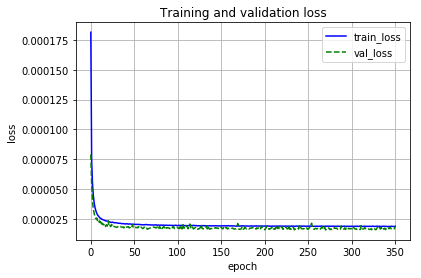

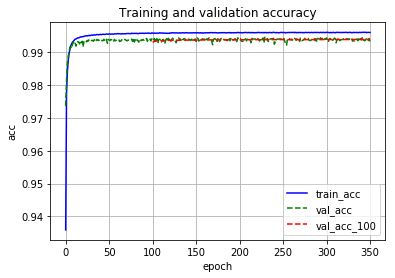

acc max step:342



Epoch [352/10000], Loss: 0.0000189134, val_loss: 0.0000167742, val_acc: 0.9941541506



Epoch [353/10000], Loss: 0.0000187849, val_loss: 0.0000177569, val_acc: 0.9937983162



Epoch [354/10000], Loss: 0.0000187868, val_loss: 0.0000174394, val_acc: 0.9937240212



Epoch [355/10000], Loss: 0.0000188795, val_loss: 0.0000170249, val_acc: 0.9942323559



Epoch [356/10000], Loss: 0.0000188608, val_loss: 0.0000171321, val_acc: 0.9937983162



Epoch [357/10000], Loss: 0.0000189381, val_loss: 0.0000164337, val_acc: 0.9941072273



Epoch [358/10000], Loss: 0.0000189769, val_loss: 0.0000172630, val_acc: 0.9938335086



Epoch [359/10000], Loss: 0.0000190622, val_loss: 0.0000161099, val_acc: 0.9942206251



Epoch [360/10000], Loss: 0.0000186912, val_loss: 0.0000165897, val_acc: 0.9942284456



Epoch [361/10000], Loss: 0.0000188825, val_loss: 0.0000165746, val_acc: 0.9939508167
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.67      0.91      0.77      1384
          ES       0.81      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



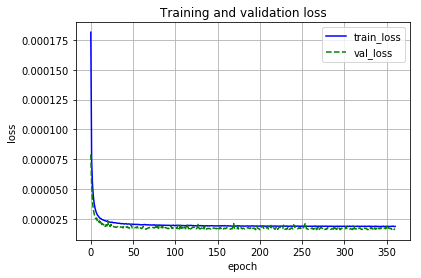

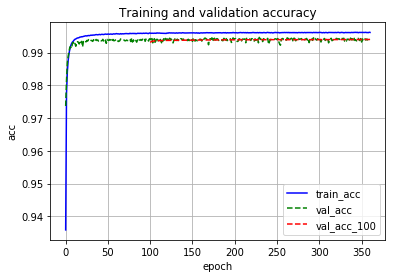

acc max step:355



Epoch [362/10000], Loss: 0.0000188554, val_loss: 0.0000173676, val_acc: 0.9939820988



Epoch [363/10000], Loss: 0.0000189231, val_loss: 0.0000165767, val_acc: 0.9939860091



Epoch [364/10000], Loss: 0.0000188495, val_loss: 0.0000166051, val_acc: 0.9940055604



Epoch [365/10000], Loss: 0.0000188108, val_loss: 0.0000208092, val_acc: 0.9926017745



Epoch [366/10000], Loss: 0.0000188094, val_loss: 0.0000163658, val_acc: 0.9939429961



Epoch [367/10000], Loss: 0.0000188519, val_loss: 0.0000162575, val_acc: 0.9942675483



Epoch [368/10000], Loss: 0.0000188832, val_loss: 0.0000170595, val_acc: 0.9940524836



Epoch [369/10000], Loss: 0.0000189097, val_loss: 0.0000165637, val_acc: 0.9942088943



Epoch [370/10000], Loss: 0.0000188617, val_loss: 0.0000165828, val_acc: 0.9942245354



Epoch [371/10000], Loss: 0.0000189006, val_loss: 0.0000162973, val_acc: 0.9943457536
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.72      0.90      0.80      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.85      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



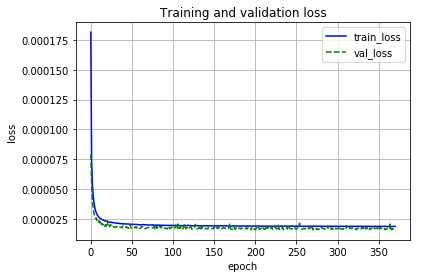

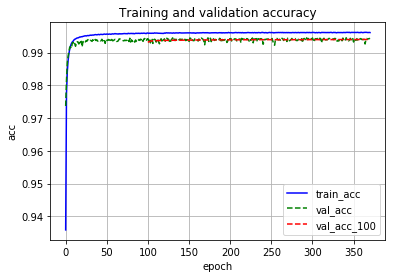

acc max step:362



Epoch [372/10000], Loss: 0.0000188553, val_loss: 0.0000163427, val_acc: 0.9946116518



Epoch [373/10000], Loss: 0.0000188479, val_loss: 0.0000180481, val_acc: 0.9936692774



Epoch [374/10000], Loss: 0.0000187635, val_loss: 0.0000167283, val_acc: 0.9940798555



Epoch [375/10000], Loss: 0.0000188467, val_loss: 0.0000166782, val_acc: 0.9942010738



Epoch [376/10000], Loss: 0.0000188199, val_loss: 0.0000179372, val_acc: 0.9936262645



Epoch [377/10000], Loss: 0.0000188645, val_loss: 0.0000171085, val_acc: 0.9939273551



Epoch [378/10000], Loss: 0.0000188197, val_loss: 0.0000161428, val_acc: 0.9943731255



Epoch [379/10000], Loss: 0.0000187697, val_loss: 0.0000169944, val_acc: 0.9938413292



Epoch [380/10000], Loss: 0.0000188514, val_loss: 0.0000166544, val_acc: 0.9943887666



Epoch [381/10000], Loss: 0.0000187402, val_loss: 0.0000165112, val_acc: 0.9941385095
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.71      0.90      0.79      1384
          ES       0.82      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



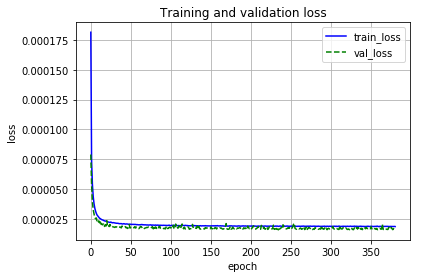

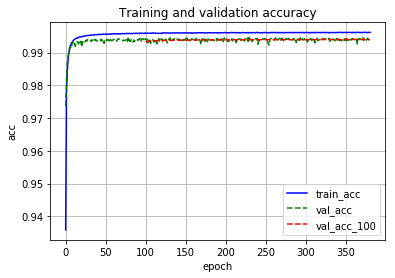

acc max step:362



Epoch [382/10000], Loss: 0.0000187233, val_loss: 0.0000169651, val_acc: 0.9940485733



Epoch [383/10000], Loss: 0.0000189841, val_loss: 0.0000165243, val_acc: 0.9943535742



Epoch [384/10000], Loss: 0.0000188545, val_loss: 0.0000168317, val_acc: 0.9942870996



Epoch [385/10000], Loss: 0.0000187501, val_loss: 0.0000167216, val_acc: 0.9946233826
Saving the checkpoint...



Epoch [386/10000], Loss: 0.0000189286, val_loss: 0.0000171519, val_acc: 0.9937201109



Epoch [387/10000], Loss: 0.0000186861, val_loss: 0.0000166472, val_acc: 0.9942284456



Epoch [388/10000], Loss: 0.0000190116, val_loss: 0.0000171329, val_acc: 0.9945021643



Epoch [389/10000], Loss: 0.0000189219, val_loss: 0.0000174569, val_acc: 0.9937513930



Epoch [390/10000], Loss: 0.0000188316, val_loss: 0.0000183442, val_acc: 0.9933603663



Epoch [391/10000], Loss: 0.0000188221, val_loss: 0.0000179127, val_acc: 0.9934620333
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.65      0.92      0.76      1384
          ES       0.77      0.99      0.86      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.81      0.96      0.87     49859
weighted avg       0.98      0.98      0.98     49859



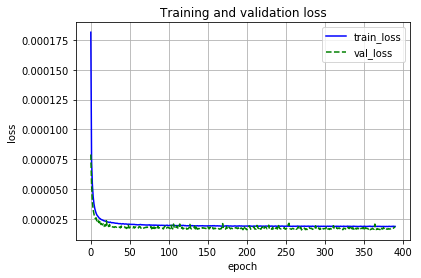

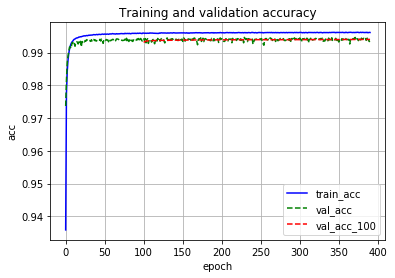

acc max step:389



Epoch [392/10000], Loss: 0.0000187510, val_loss: 0.0000163742, val_acc: 0.9944552411



Epoch [393/10000], Loss: 0.0000188412, val_loss: 0.0000167213, val_acc: 0.9940681247



Epoch [399/10000], Loss: 0.0000188608, val_loss: 0.0000222043, val_acc: 0.9922146580



Epoch [400/10000], Loss: 0.0000188022, val_loss: 0.0000168418, val_acc: 0.9943066510



Epoch [401/10000], Loss: 0.0000188773, val_loss: 0.0000178395, val_acc: 0.9935715207
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.65      0.91      0.76      1384
          ES       0.77      0.99      0.87      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.81      0.96      0.87     49859
weighted avg       0.98      0.98      0.98     49859



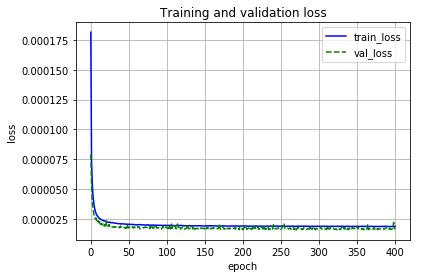

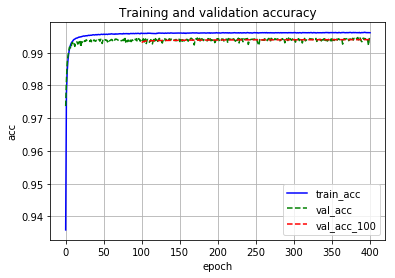

acc max step:389



Epoch [402/10000], Loss: 0.0000186852, val_loss: 0.0000162881, val_acc: 0.9944200487



Epoch [403/10000], Loss: 0.0000189192, val_loss: 0.0000166917, val_acc: 0.9944278693



Epoch [404/10000], Loss: 0.0000189526, val_loss: 0.0000165550, val_acc: 0.9940329323



Epoch [405/10000], Loss: 0.0000187952, val_loss: 0.0000166467, val_acc: 0.9943496639



Epoch [406/10000], Loss: 0.0000187508, val_loss: 0.0000174149, val_acc: 0.9936458158



Epoch [407/10000], Loss: 0.0000186537, val_loss: 0.0000161669, val_acc: 0.9942949202



Epoch [408/10000], Loss: 0.0000186914, val_loss: 0.0000178690, val_acc: 0.9939273551


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch [439/10000], Loss: 0.0000187757, val_loss: 0.0000172667, val_acc: 0.9938022265



Epoch [440/10000], Loss: 0.0000186352, val_loss: 0.0000171368, val_acc: 0.9944591514



Epoch [441/10000], Loss: 0.0000186886, val_loss: 0.0000163386, val_acc: 0.9941385095
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.69      0.91      0.79      1384
          ES       0.80      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



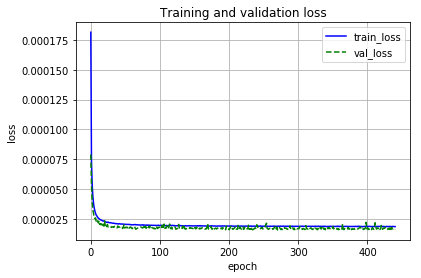

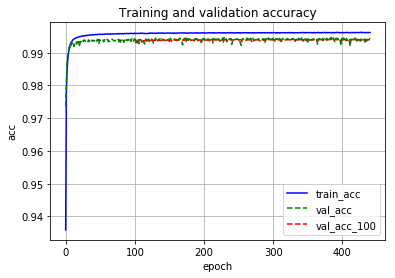

acc max step:389



Epoch [442/10000], Loss: 0.0000188279, val_loss: 0.0000167899, val_acc: 0.9942597278



Epoch [443/10000], Loss: 0.0000187187, val_loss: 0.0000171603, val_acc: 0.9938139573



Epoch [444/10000], Loss: 0.0000187507, val_loss: 0.0000161956, val_acc: 0.9943887666



Epoch [445/10000], Loss: 0.0000187826, val_loss: 0.0000169884, val_acc: 0.9938256881



Epoch [446/10000], Loss: 0.0000187537, val_loss: 0.0000175101, val_acc: 0.9935910721



Epoch [447/10000], Loss: 0.0000186860, val_loss: 0.0000170883, val_acc: 0.9943418434



Epoch [448/10000], Loss: 0.0000187381, val_loss: 0.0000167154, val_acc: 0.9940994068



Epoch [449/10000], Loss: 0.0000187131, val_loss: 0.0000160945, val_acc: 0.9943027407



Epoch [450/10000], Loss: 0.0000187775, val_loss: 0.0000170851, val_acc: 0.9939429961



Epoch [451/10000], Loss: 0.0000188685, val_loss: 0.0000167755, val_acc: 0.9943887666
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     47091
          BS       0.76      0.88      0.81      1384
          ES       0.82      0.99      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.86      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



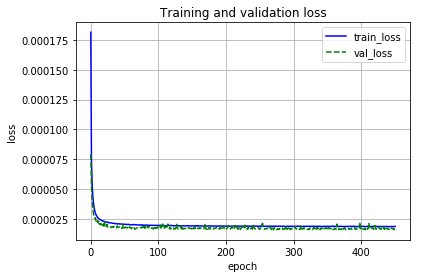

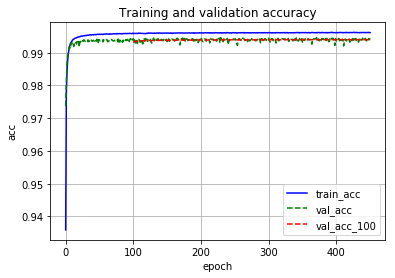

acc max step:389



Epoch [452/10000], Loss: 0.0000185687, val_loss: 0.0000171708, val_acc: 0.9939860091



Epoch [453/10000], Loss: 0.0000187283, val_loss: 0.0000166351, val_acc: 0.9939586372



Epoch [454/10000], Loss: 0.0000186665, val_loss: 0.0000166344, val_acc: 0.9941971635



Epoch [455/10000], Loss: 0.0000189313, val_loss: 0.0000168111, val_acc: 0.9940485733



Epoch [456/10000], Loss: 0.0000187688, val_loss: 0.0000167746, val_acc: 0.9941111376



Epoch [457/10000], Loss: 0.0000187652, val_loss: 0.0000166733, val_acc: 0.9942245354



Epoch [458/10000], Loss: 0.0000187115, val_loss: 0.0000177147, val_acc: 0.9937162006



Epoch [459/10000], Loss: 0.0000187656, val_loss: 0.0000176179, val_acc: 0.9937005596



Epoch [460/10000], Loss: 0.0000188299, val_loss: 0.0000177397, val_acc: 0.9935597899



Epoch [461/10000], Loss: 0.0000187709, val_loss: 0.0000193003, val_acc: 0.9931922248
              precision    recall  f1-score   support

           O       1.00      0.97      0.99     47091
          BS       0.63      0.92      0.75      1384
          ES       0.75      0.99      0.85      1384

   micro avg       0.97      0.97      0.97     49859
   macro avg       0.79      0.96      0.86     49859
weighted avg       0.98      0.97      0.98     49859



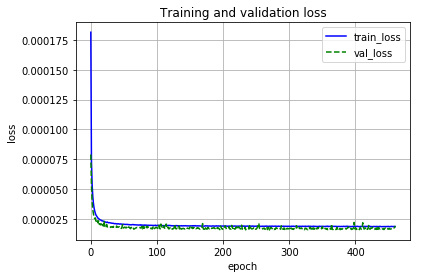

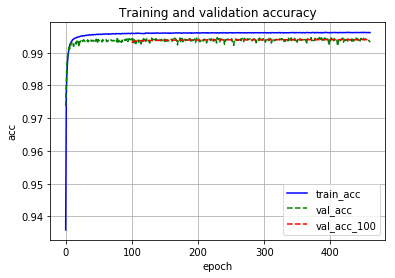

acc max step:389



Epoch [462/10000], Loss: 0.0000188674, val_loss: 0.0000164327, val_acc: 0.9943809461



Epoch [463/10000], Loss: 0.0000186390, val_loss: 0.0000177129, val_acc: 0.9936340850



Epoch [464/10000], Loss: 0.0000186530, val_loss: 0.0000167291, val_acc: 0.9940407528



Epoch [465/10000], Loss: 0.0000188181, val_loss: 0.0000162160, val_acc: 0.9945295362



Epoch [466/10000], Loss: 0.0000187479, val_loss: 0.0000169362, val_acc: 0.9939586372



Epoch [467/10000], Loss: 0.0000187858, val_loss: 0.0000171677, val_acc: 0.9937904957



Epoch [468/10000], Loss: 0.0000187758, val_loss: 0.0000166282, val_acc: 0.9941306889



Epoch [469/10000], Loss: 0.0000188045, val_loss: 0.0000178422, val_acc: 0.9934854949



Epoch [470/10000], Loss: 0.0000187516, val_loss: 0.0000176267, val_acc: 0.9935949823



Epoch [471/10000], Loss: 0.0000187946, val_loss: 0.0000167984, val_acc: 0.9939664577
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.67      0.91      0.77      1384
          ES       0.81      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



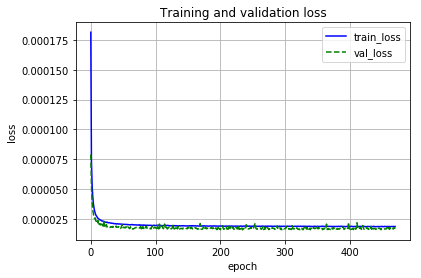

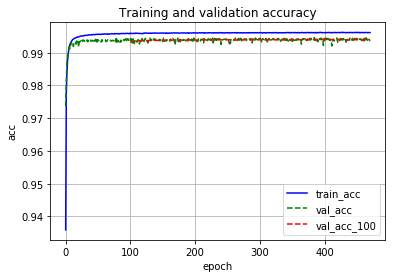

acc max step:389



Epoch [472/10000], Loss: 0.0000187844, val_loss: 0.0000167324, val_acc: 0.9941345992



Epoch [473/10000], Loss: 0.0000187976, val_loss: 0.0000168077, val_acc: 0.9943379331



Epoch [474/10000], Loss: 0.0000185981, val_loss: 0.0000161713, val_acc: 0.9942440867



Epoch [475/10000], Loss: 0.0000187375, val_loss: 0.0000167121, val_acc: 0.9940720349



Epoch [476/10000], Loss: 0.0000187596, val_loss: 0.0000181389, val_acc: 0.9934581230



Epoch [477/10000], Loss: 0.0000188152, val_loss: 0.0000166720, val_acc: 0.9940720349



Epoch [478/10000], Loss: 0.0000186539, val_loss: 0.0000185176, val_acc: 0.9933329944



Epoch [479/10000], Loss: 0.0000187167, val_loss: 0.0000162570, val_acc: 0.9941502403



Epoch [480/10000], Loss: 0.0000186145, val_loss: 0.0000163050, val_acc: 0.9942206251



Epoch [481/10000], Loss: 0.0000187015, val_loss: 0.0000189626, val_acc: 0.9932117762
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.65      0.92      0.76      1384
          ES       0.75      0.98      0.85      1384

   micro avg       0.97      0.97      0.97     49859
   macro avg       0.80      0.96      0.87     49859
weighted avg       0.98      0.97      0.98     49859



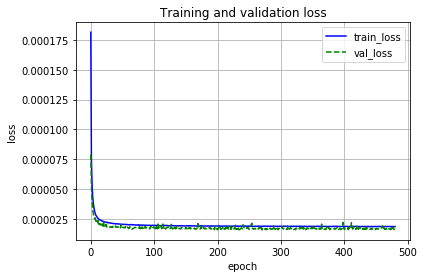

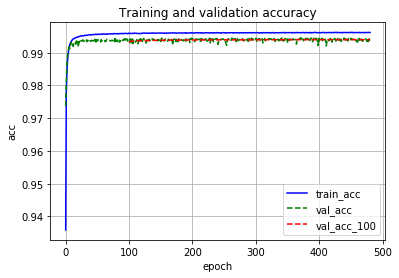

acc max step:389



Epoch [482/10000], Loss: 0.0000187901, val_loss: 0.0000168638, val_acc: 0.9939312653



Epoch [483/10000], Loss: 0.0000188524, val_loss: 0.0000170456, val_acc: 0.9940994068



Epoch [484/10000], Loss: 0.0000186517, val_loss: 0.0000165386, val_acc: 0.9941737019



Epoch [485/10000], Loss: 0.0000186291, val_loss: 0.0000170297, val_acc: 0.9937944060



Epoch [486/10000], Loss: 0.0000188375, val_loss: 0.0000162914, val_acc: 0.9942010738



Epoch [487/10000], Loss: 0.0000186626, val_loss: 0.0000165861, val_acc: 0.9940407528



Epoch [488/10000], Loss: 0.0000187930, val_loss: 0.0000182250, val_acc: 0.9933877382



Epoch [489/10000], Loss: 0.0000187343, val_loss: 0.0000182524, val_acc: 0.9943613947



Epoch [490/10000], Loss: 0.0000186607, val_loss: 0.0000163885, val_acc: 0.9941815224



Epoch [491/10000], Loss: 0.0000186540, val_loss: 0.0000166241, val_acc: 0.9943731255
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     47091
          BS       0.73      0.89      0.80      1384
          ES       0.85      0.98      0.91      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.86      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



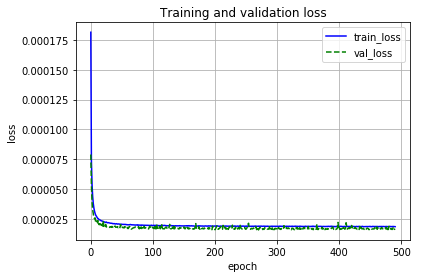

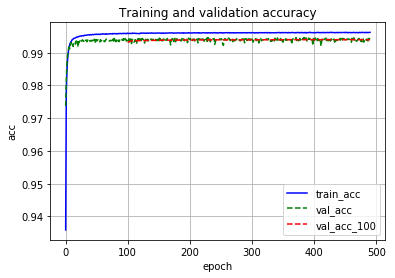

acc max step:389



Epoch [492/10000], Loss: 0.0000186548, val_loss: 0.0000160260, val_acc: 0.9941385095



Epoch [493/10000], Loss: 0.0000188927, val_loss: 0.0000167997, val_acc: 0.9940055604



Epoch [494/10000], Loss: 0.0000187006, val_loss: 0.0000167656, val_acc: 0.9942010738



Epoch [495/10000], Loss: 0.0000189425, val_loss: 0.0000175324, val_acc: 0.9935832515



Epoch [496/10000], Loss: 0.0000186155, val_loss: 0.0000165305, val_acc: 0.9940251117



Epoch [497/10000], Loss: 0.0000186835, val_loss: 0.0000171026, val_acc: 0.9941228684



Epoch [498/10000], Loss: 0.0000187284, val_loss: 0.0000165418, val_acc: 0.9941111376



Epoch [499/10000], Loss: 0.0000186669, val_loss: 0.0000163638, val_acc: 0.9942870996



Epoch [500/10000], Loss: 0.0000186522, val_loss: 0.0000206092, val_acc: 0.9927777365



Epoch [501/10000], Loss: 0.0000187380, val_loss: 0.0000162728, val_acc: 0.9941502403
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.71      0.90      0.79      1384
          ES       0.82      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



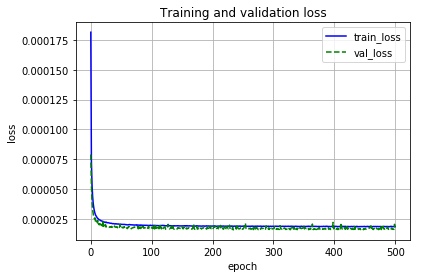

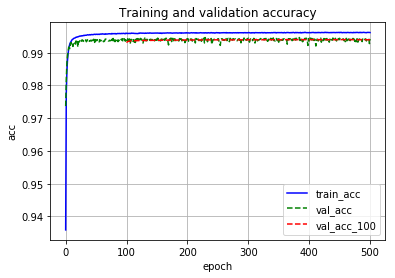

acc max step:389



Epoch [502/10000], Loss: 0.0000186183, val_loss: 0.0000168887, val_acc: 0.9940837657



Epoch [503/10000], Loss: 0.0000188371, val_loss: 0.0000167556, val_acc: 0.9943848563



Epoch [504/10000], Loss: 0.0000188526, val_loss: 0.0000167660, val_acc: 0.9939820988



Epoch [505/10000], Loss: 0.0000186118, val_loss: 0.0000174943, val_acc: 0.9936575466



Epoch [506/10000], Loss: 0.0000188186, val_loss: 0.0000171521, val_acc: 0.9944122282



Epoch [507/10000], Loss: 0.0000188086, val_loss: 0.0000163125, val_acc: 0.9942988304



Epoch [508/10000], Loss: 0.0000186916, val_loss: 0.0000178310, val_acc: 0.9935285078



Epoch [509/10000], Loss: 0.0000186987, val_loss: 0.0000163361, val_acc: 0.9943965871



Epoch [510/10000], Loss: 0.0000188380, val_loss: 0.0000163713, val_acc: 0.9940759452



Epoch [511/10000], Loss: 0.0000189036, val_loss: 0.0000165197, val_acc: 0.9942245354
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.69      0.90      0.78      1384
          ES       0.82      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



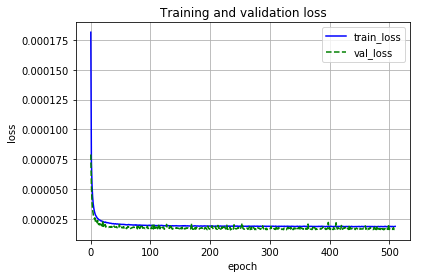

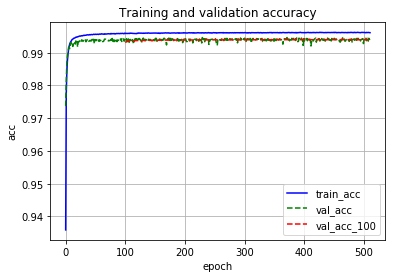

acc max step:389



Epoch [512/10000], Loss: 0.0000187694, val_loss: 0.0000169497, val_acc: 0.9939078037



Epoch [513/10000], Loss: 0.0000186821, val_loss: 0.0000161681, val_acc: 0.9944239590



Epoch [514/10000], Loss: 0.0000187507, val_loss: 0.0000203027, val_acc: 0.9938374189



Epoch [515/10000], Loss: 0.0000187828, val_loss: 0.0000177059, val_acc: 0.9934776743



Epoch [516/10000], Loss: 0.0000187094, val_loss: 0.0000162464, val_acc: 0.9942440867



Epoch [517/10000], Loss: 0.0000187171, val_loss: 0.0000167584, val_acc: 0.9939860091



Epoch [518/10000], Loss: 0.0000187743, val_loss: 0.0000169736, val_acc: 0.9942870996



Epoch [519/10000], Loss: 0.0000187824, val_loss: 0.0000201144, val_acc: 0.9937592136



Epoch [520/10000], Loss: 0.0000187677, val_loss: 0.0000163213, val_acc: 0.9942284456



Epoch [521/10000], Loss: 0.0000185287, val_loss: 0.0000179993, val_acc: 0.9947289598
Saving the checkpoint...
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     47091
          BS       0.78      0.88      0.83      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.87      0.95      0.90     49859
weighted avg       0.99      0.98      0.98     49859



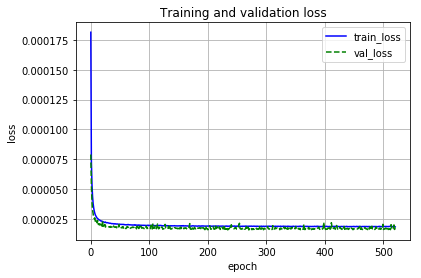

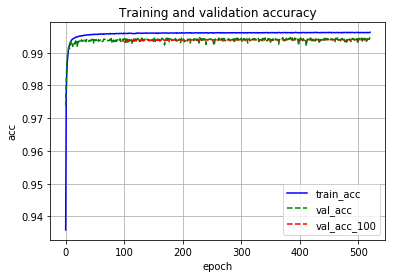

acc max step:389



Epoch [522/10000], Loss: 0.0000187463, val_loss: 0.0000170767, val_acc: 0.9939508167



Epoch [523/10000], Loss: 0.0000187703, val_loss: 0.0000183412, val_acc: 0.9934659435



Epoch [524/10000], Loss: 0.0000187120, val_loss: 0.0000168083, val_acc: 0.9940407528



Epoch [525/10000], Loss: 0.0000187477, val_loss: 0.0000169286, val_acc: 0.9938765216



Epoch [526/10000], Loss: 0.0000186424, val_loss: 0.0000170696, val_acc: 0.9938882524



Epoch [527/10000], Loss: 0.0000189347, val_loss: 0.0000167260, val_acc: 0.9941150479



Epoch [528/10000], Loss: 0.0000187412, val_loss: 0.0000161586, val_acc: 0.9943457536



Epoch [529/10000], Loss: 0.0000186948, val_loss: 0.0000169104, val_acc: 0.9940407528



Epoch [530/10000], Loss: 0.0000187173, val_loss: 0.0000162023, val_acc: 0.9943027407



Epoch [531/10000], Loss: 0.0000185843, val_loss: 0.0000174021, val_acc: 0.9944122282
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.75      0.88      0.81      1384
          ES       0.80      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.85      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



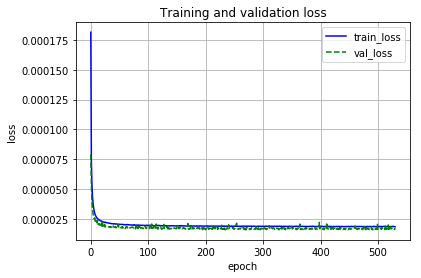

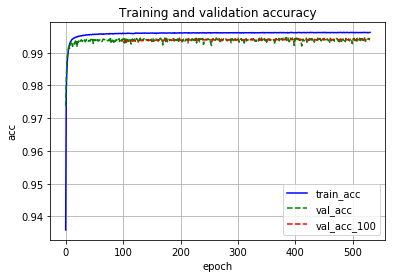

acc max step:389



Epoch [532/10000], Loss: 0.0000187826, val_loss: 0.0000168010, val_acc: 0.9942479970



Epoch [533/10000], Loss: 0.0000186832, val_loss: 0.0000182837, val_acc: 0.9939938296



Epoch [534/10000], Loss: 0.0000187298, val_loss: 0.0000166532, val_acc: 0.9942206251



Epoch [535/10000], Loss: 0.0000185807, val_loss: 0.0000166941, val_acc: 0.9940681247



Epoch [536/10000], Loss: 0.0000186777, val_loss: 0.0000175443, val_acc: 0.9937787649



Epoch [537/10000], Loss: 0.0000187826, val_loss: 0.0000164077, val_acc: 0.9942010738



Epoch [538/10000], Loss: 0.0000187802, val_loss: 0.0000165687, val_acc: 0.9940876760



Epoch [539/10000], Loss: 0.0000186050, val_loss: 0.0000182594, val_acc: 0.9932938918



Epoch [540/10000], Loss: 0.0000185933, val_loss: 0.0000165850, val_acc: 0.9940407528



Epoch [541/10000], Loss: 0.0000187374, val_loss: 0.0000171716, val_acc: 0.9937983162
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.66      0.91      0.77      1384
          ES       0.78      0.99      0.87      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.81      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



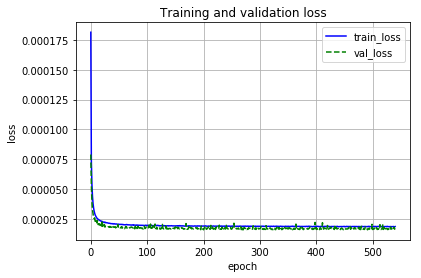

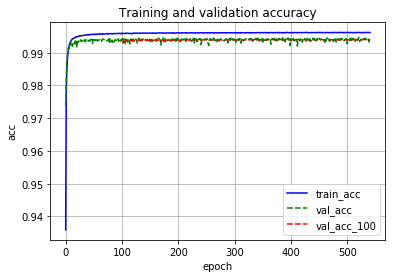

acc max step:538



Epoch [542/10000], Loss: 0.0000187528, val_loss: 0.0000165192, val_acc: 0.9939860091



Epoch [543/10000], Loss: 0.0000187378, val_loss: 0.0000167487, val_acc: 0.9940055604



Epoch [544/10000], Loss: 0.0000187379, val_loss: 0.0000166674, val_acc: 0.9944239590



Epoch [545/10000], Loss: 0.0000187502, val_loss: 0.0000167633, val_acc: 0.9941776122



Epoch [546/10000], Loss: 0.0000187847, val_loss: 0.0000164972, val_acc: 0.9940681247



Epoch [547/10000], Loss: 0.0000187255, val_loss: 0.0000169824, val_acc: 0.9938882524



Epoch [548/10000], Loss: 0.0000187817, val_loss: 0.0000162258, val_acc: 0.9943301126



Epoch [549/10000], Loss: 0.0000187751, val_loss: 0.0000166795, val_acc: 0.9940954965



Epoch [550/10000], Loss: 0.0000187451, val_loss: 0.0000159993, val_acc: 0.9944630617



Epoch [551/10000], Loss: 0.0000188129, val_loss: 0.0000173514, val_acc: 0.9938452394
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.69      0.91      0.78      1384
          ES       0.78      0.99      0.87      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



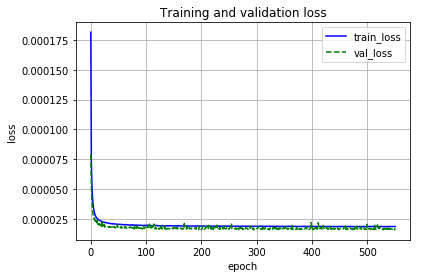

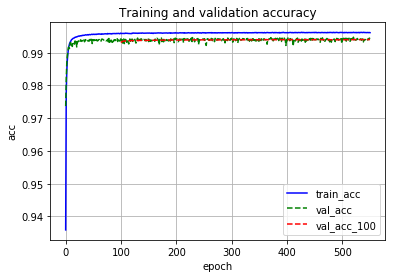

acc max step:538



Epoch [552/10000], Loss: 0.0000185343, val_loss: 0.0000161128, val_acc: 0.9940915863



Epoch [553/10000], Loss: 0.0000187456, val_loss: 0.0000169186, val_acc: 0.9938843421



Epoch [554/10000], Loss: 0.0000187226, val_loss: 0.0000199168, val_acc: 0.9929536985



Epoch [555/10000], Loss: 0.0000185753, val_loss: 0.0000176276, val_acc: 0.9936927390



Epoch [556/10000], Loss: 0.0000187286, val_loss: 0.0000209777, val_acc: 0.9924805562



Epoch [557/10000], Loss: 0.0000186748, val_loss: 0.0000168379, val_acc: 0.9939390859



Epoch [558/10000], Loss: 0.0000185678, val_loss: 0.0000161307, val_acc: 0.9941385095



Epoch [559/10000], Loss: 0.0000186865, val_loss: 0.0000168328, val_acc: 0.9940485733



Epoch [560/10000], Loss: 0.0000187988, val_loss: 0.0000163532, val_acc: 0.9942479970



Epoch [561/10000], Loss: 0.0000186072, val_loss: 0.0000178365, val_acc: 0.9939703680
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     47091
          BS       0.74      0.89      0.81      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.86      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



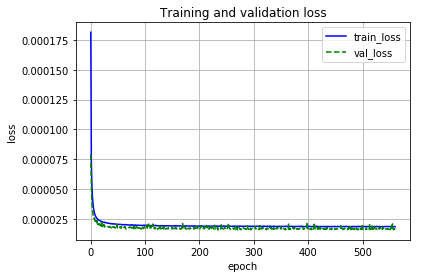

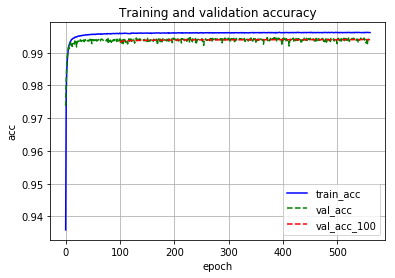

acc max step:538



Epoch [562/10000], Loss: 0.0000186493, val_loss: 0.0000161140, val_acc: 0.9943340228



Epoch [563/10000], Loss: 0.0000186132, val_loss: 0.0000164812, val_acc: 0.9941502403



Epoch [564/10000], Loss: 0.0000186893, val_loss: 0.0000169401, val_acc: 0.9939390859



Epoch [565/10000], Loss: 0.0000186267, val_loss: 0.0000165590, val_acc: 0.9941150479



Epoch [566/10000], Loss: 0.0000188841, val_loss: 0.0000164970, val_acc: 0.9939860091



Epoch [567/10000], Loss: 0.0000185815, val_loss: 0.0000161937, val_acc: 0.9942245354



Epoch [568/10000], Loss: 0.0000188309, val_loss: 0.0000173975, val_acc: 0.9937631238



Epoch [569/10000], Loss: 0.0000187098, val_loss: 0.0000164746, val_acc: 0.9944044077



Epoch [570/10000], Loss: 0.0000186904, val_loss: 0.0000163571, val_acc: 0.9941267787



Epoch [571/10000], Loss: 0.0000185755, val_loss: 0.0000170084, val_acc: 0.9938491497
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.67      0.91      0.77      1384
          ES       0.79      0.99      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



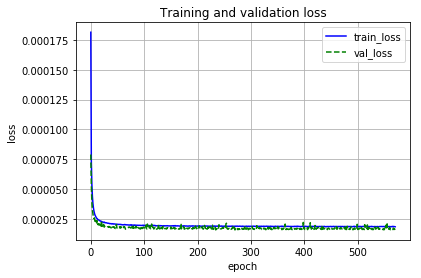

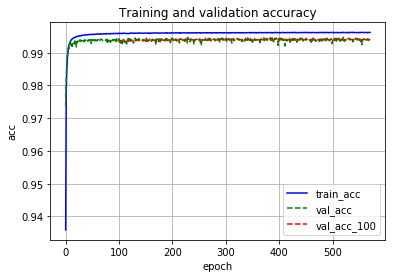

acc max step:538



Epoch [572/10000], Loss: 0.0000186760, val_loss: 0.0000166965, val_acc: 0.9943183818



Epoch [573/10000], Loss: 0.0000187220, val_loss: 0.0000163420, val_acc: 0.9940681247



Epoch [574/10000], Loss: 0.0000187147, val_loss: 0.0000173494, val_acc: 0.9937122904



Epoch [575/10000], Loss: 0.0000187640, val_loss: 0.0000165506, val_acc: 0.9941854327



Epoch [576/10000], Loss: 0.0000186761, val_loss: 0.0000165393, val_acc: 0.9942401764



Epoch [577/10000], Loss: 0.0000187757, val_loss: 0.0000159731, val_acc: 0.9941893430



Epoch [578/10000], Loss: 0.0000187685, val_loss: 0.0000169789, val_acc: 0.9943301126



Epoch [579/10000], Loss: 0.0000186483, val_loss: 0.0000169757, val_acc: 0.9942206251



Epoch [580/10000], Loss: 0.0000185601, val_loss: 0.0000168711, val_acc: 0.9940407528



Epoch [581/10000], Loss: 0.0000187178, val_loss: 0.0000166969, val_acc: 0.9943887666
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.73      0.90      0.80      1384
          ES       0.81      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



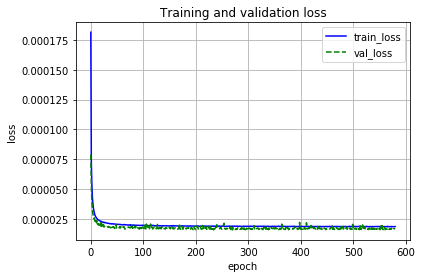

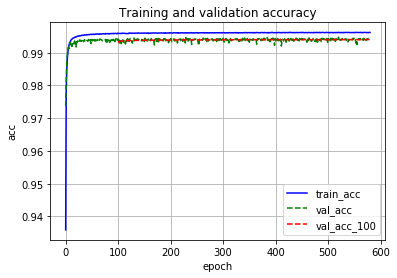

acc max step:579



Epoch [582/10000], Loss: 0.0000185671, val_loss: 0.0000168277, val_acc: 0.9941619711



Epoch [583/10000], Loss: 0.0000187367, val_loss: 0.0000199271, val_acc: 0.9929693396



Epoch [584/10000], Loss: 0.0000188446, val_loss: 0.0000160188, val_acc: 0.9944708822



Epoch [585/10000], Loss: 0.0000187516, val_loss: 0.0000169375, val_acc: 0.9938726113



Epoch [586/10000], Loss: 0.0000186146, val_loss: 0.0000172575, val_acc: 0.9937279314



Epoch [587/10000], Loss: 0.0000186450, val_loss: 0.0000173968, val_acc: 0.9939781885



Epoch [588/10000], Loss: 0.0000187775, val_loss: 0.0000172483, val_acc: 0.9937513930



Epoch [589/10000], Loss: 0.0000188730, val_loss: 0.0000163445, val_acc: 0.9941854327



Epoch [590/10000], Loss: 0.0000186431, val_loss: 0.0000163669, val_acc: 0.9943457536



Epoch [591/10000], Loss: 0.0000186258, val_loss: 0.0000187411, val_acc: 0.9933760074
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.64      0.92      0.75      1384
          ES       0.80      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.81      0.96      0.87     49859
weighted avg       0.98      0.98      0.98     49859



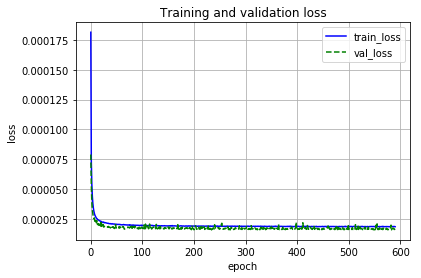

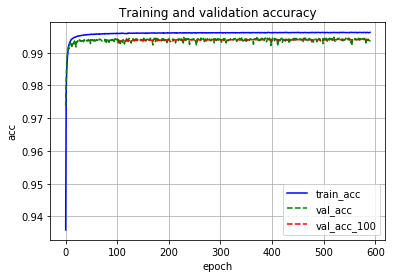

acc max step:582



Epoch [592/10000], Loss: 0.0000185777, val_loss: 0.0000160640, val_acc: 0.9940642144



Epoch [593/10000], Loss: 0.0000186046, val_loss: 0.0000168673, val_acc: 0.9939742783



Epoch [594/10000], Loss: 0.0000186271, val_loss: 0.0000178596, val_acc: 0.9934581230



Epoch [595/10000], Loss: 0.0000185881, val_loss: 0.0000174801, val_acc: 0.9938921627



Epoch [596/10000], Loss: 0.0000186513, val_loss: 0.0000176498, val_acc: 0.9937435725



Epoch [597/10000], Loss: 0.0000185169, val_loss: 0.0000169159, val_acc: 0.9940681247



Epoch [598/10000], Loss: 0.0000187580, val_loss: 0.0000169986, val_acc: 0.9943965871



Epoch [599/10000], Loss: 0.0000186927, val_loss: 0.0000179875, val_acc: 0.9934737641



Epoch [600/10000], Loss: 0.0000187557, val_loss: 0.0000203094, val_acc: 0.9930162628



Epoch [601/10000], Loss: 0.0000185116, val_loss: 0.0000176313, val_acc: 0.9936653672
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.64      0.91      0.75      1384
          ES       0.82      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



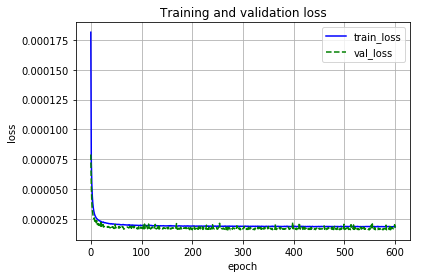

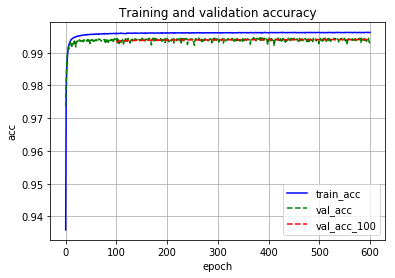

acc max step:582



Epoch [602/10000], Loss: 0.0000185667, val_loss: 0.0000242938, val_acc: 0.9914599765



Epoch [603/10000], Loss: 0.0000187758, val_loss: 0.0000170273, val_acc: 0.9942519072



Epoch [604/10000], Loss: 0.0000185984, val_loss: 0.0000166254, val_acc: 0.9939195345



Epoch [605/10000], Loss: 0.0000187420, val_loss: 0.0000165172, val_acc: 0.9941424198



Epoch [606/10000], Loss: 0.0000188076, val_loss: 0.0000172196, val_acc: 0.9938530600



Epoch [607/10000], Loss: 0.0000185217, val_loss: 0.0000170106, val_acc: 0.9938374189



Epoch [608/10000], Loss: 0.0000187474, val_loss: 0.0000166158, val_acc: 0.9940016501



Epoch [609/10000], Loss: 0.0000185616, val_loss: 0.0000161761, val_acc: 0.9943770358



Epoch [610/10000], Loss: 0.0000187022, val_loss: 0.0000169593, val_acc: 0.9940055604



Epoch [611/10000], Loss: 0.0000186979, val_loss: 0.0000168278, val_acc: 0.9940094707
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.68      0.91      0.78      1384
          ES       0.85      0.98      0.91      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



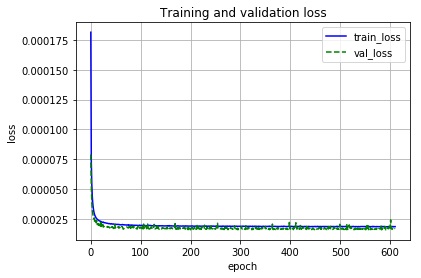

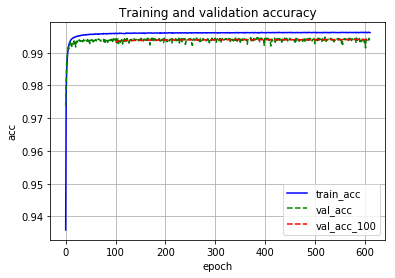

acc max step:582



Epoch [612/10000], Loss: 0.0000185586, val_loss: 0.0000166560, val_acc: 0.9941189581



Epoch [613/10000], Loss: 0.0000186967, val_loss: 0.0000164618, val_acc: 0.9942440867



Epoch [614/10000], Loss: 0.0000187059, val_loss: 0.0000163781, val_acc: 0.9941697916



Epoch [615/10000], Loss: 0.0000186771, val_loss: 0.0000171224, val_acc: 0.9937670341



Epoch [616/10000], Loss: 0.0000185606, val_loss: 0.0000170267, val_acc: 0.9938217778



Epoch [617/10000], Loss: 0.0000185500, val_loss: 0.0000164708, val_acc: 0.9944004974



Epoch [618/10000], Loss: 0.0000186956, val_loss: 0.0000161374, val_acc: 0.9944630617



Epoch [619/10000], Loss: 0.0000186832, val_loss: 0.0000166257, val_acc: 0.9939351756



Epoch [620/10000], Loss: 0.0000185717, val_loss: 0.0000166675, val_acc: 0.9944396001



Epoch [621/10000], Loss: 0.0000186829, val_loss: 0.0000163639, val_acc: 0.9941424198
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.71      0.90      0.80      1384
          ES       0.81      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



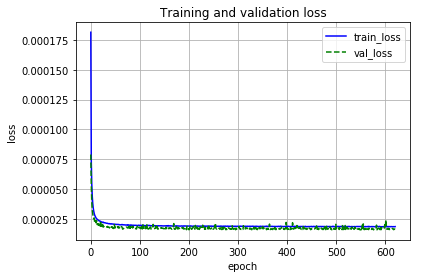

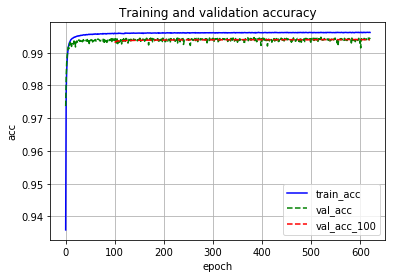

acc max step:582



Epoch [622/10000], Loss: 0.0000186851, val_loss: 0.0000163575, val_acc: 0.9941424198



Epoch [623/10000], Loss: 0.0000187030, val_loss: 0.0000173026, val_acc: 0.9936927390



Epoch [624/10000], Loss: 0.0000186412, val_loss: 0.0000173646, val_acc: 0.9936067131



Epoch [625/10000], Loss: 0.0000185464, val_loss: 0.0000161455, val_acc: 0.9941424198



Epoch [626/10000], Loss: 0.0000186433, val_loss: 0.0000175535, val_acc: 0.9937787649



Epoch [627/10000], Loss: 0.0000187381, val_loss: 0.0000169020, val_acc: 0.9941463300



Epoch [628/10000], Loss: 0.0000187555, val_loss: 0.0000170442, val_acc: 0.9941345992



Epoch [629/10000], Loss: 0.0000186546, val_loss: 0.0000179141, val_acc: 0.9942088943



Epoch [630/10000], Loss: 0.0000187991, val_loss: 0.0000166180, val_acc: 0.9942401764



Epoch [631/10000], Loss: 0.0000187132, val_loss: 0.0000165830, val_acc: 0.9940172912
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.69      0.91      0.78      1384
          ES       0.80      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



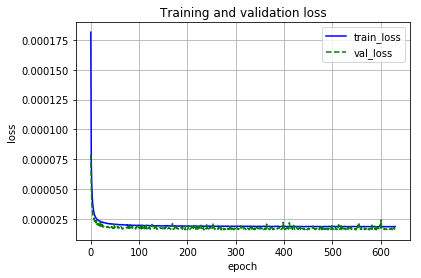

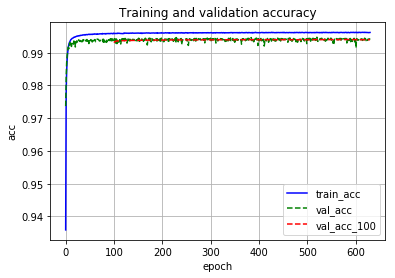

acc max step:582



Epoch [632/10000], Loss: 0.0000185200, val_loss: 0.0000167749, val_acc: 0.9943301126



Epoch [633/10000], Loss: 0.0000188084, val_loss: 0.0000170600, val_acc: 0.9939664577



Epoch [634/10000], Loss: 0.0000184084, val_loss: 0.0000173740, val_acc: 0.9940094707



Epoch [635/10000], Loss: 0.0000186712, val_loss: 0.0000167828, val_acc: 0.9945647286



Epoch [636/10000], Loss: 0.0000187741, val_loss: 0.0000178563, val_acc: 0.9935793413



Epoch [637/10000], Loss: 0.0000186325, val_loss: 0.0000164293, val_acc: 0.9941697916



Epoch [638/10000], Loss: 0.0000185822, val_loss: 0.0000163035, val_acc: 0.9943379331



Epoch [639/10000], Loss: 0.0000185919, val_loss: 0.0000172424, val_acc: 0.9938374189



Epoch [640/10000], Loss: 0.0000187102, val_loss: 0.0000163345, val_acc: 0.9943379331



Epoch [641/10000], Loss: 0.0000185798, val_loss: 0.0000173672, val_acc: 0.9944708822
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     47091
          BS       0.75      0.88      0.81      1384
          ES       0.84      0.98      0.91      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.86      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



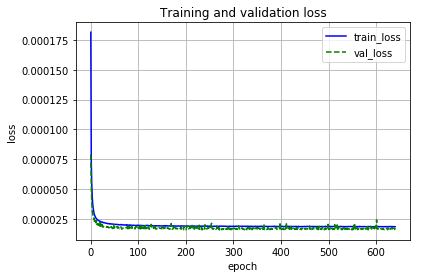

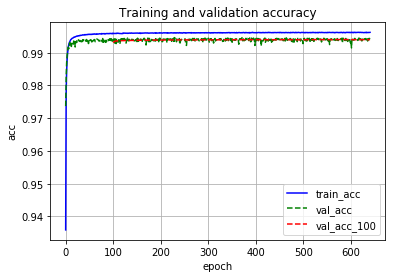

acc max step:582



Epoch [642/10000], Loss: 0.0000188011, val_loss: 0.0000163241, val_acc: 0.9942597278



Epoch [643/10000], Loss: 0.0000186185, val_loss: 0.0000170107, val_acc: 0.9937904957



Epoch [644/10000], Loss: 0.0000185145, val_loss: 0.0000173885, val_acc: 0.9937670341



Epoch [645/10000], Loss: 0.0000186555, val_loss: 0.0000178338, val_acc: 0.9934581230



Epoch [646/10000], Loss: 0.0000186855, val_loss: 0.0000161708, val_acc: 0.9942597278



Epoch [647/10000], Loss: 0.0000186548, val_loss: 0.0000160667, val_acc: 0.9943066510



Epoch [648/10000], Loss: 0.0000187373, val_loss: 0.0000163417, val_acc: 0.9941033171



Epoch [649/10000], Loss: 0.0000186592, val_loss: 0.0000184092, val_acc: 0.9931492119



Epoch [650/10000], Loss: 0.0000185217, val_loss: 0.0000170105, val_acc: 0.9939586372



Epoch [651/10000], Loss: 0.0000186034, val_loss: 0.0000161998, val_acc: 0.9940954965
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.66      0.91      0.77      1384
          ES       0.82      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



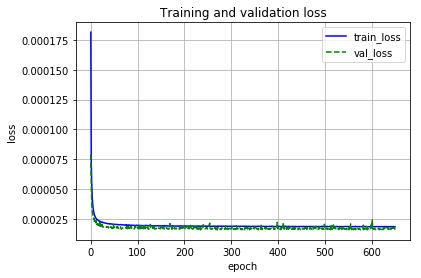

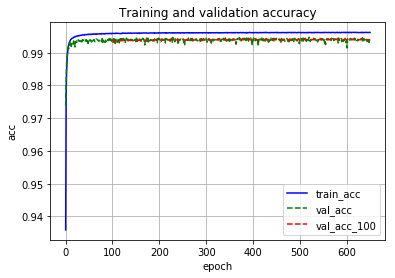

acc max step:582



Epoch [652/10000], Loss: 0.0000185050, val_loss: 0.0000171022, val_acc: 0.9939156243



Epoch [653/10000], Loss: 0.0000186603, val_loss: 0.0000180656, val_acc: 0.9934933154



Epoch [654/10000], Loss: 0.0000185430, val_loss: 0.0000162642, val_acc: 0.9941033171



Epoch [655/10000], Loss: 0.0000187287, val_loss: 0.0000163108, val_acc: 0.9943066510



Epoch [656/10000], Loss: 0.0000186434, val_loss: 0.0000166679, val_acc: 0.9938569702



Epoch [657/10000], Loss: 0.0000187252, val_loss: 0.0000177801, val_acc: 0.9940368425



Epoch [658/10000], Loss: 0.0000186632, val_loss: 0.0000174960, val_acc: 0.9936849185



Epoch [659/10000], Loss: 0.0000186422, val_loss: 0.0000168228, val_acc: 0.9938726113



Epoch [660/10000], Loss: 0.0000185191, val_loss: 0.0000168858, val_acc: 0.9941854327



Epoch [661/10000], Loss: 0.0000187795, val_loss: 0.0000173613, val_acc: 0.9941697916
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.72      0.91      0.80      1384
          ES       0.81      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



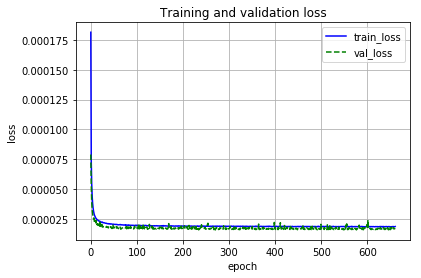

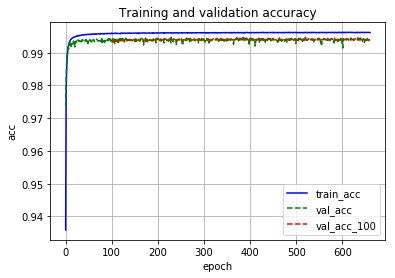

acc max step:582



Epoch [662/10000], Loss: 0.0000186058, val_loss: 0.0000168199, val_acc: 0.9940212015



Epoch [663/10000], Loss: 0.0000186239, val_loss: 0.0000168070, val_acc: 0.9937865854



Epoch [664/10000], Loss: 0.0000187510, val_loss: 0.0000179763, val_acc: 0.9935597899



Epoch [665/10000], Loss: 0.0000186555, val_loss: 0.0000171377, val_acc: 0.9942831894



Epoch [666/10000], Loss: 0.0000186469, val_loss: 0.0000190995, val_acc: 0.9930788271



Epoch [667/10000], Loss: 0.0000186638, val_loss: 0.0000164576, val_acc: 0.9941815224



Epoch [668/10000], Loss: 0.0000186676, val_loss: 0.0000167906, val_acc: 0.9940954965



Epoch [669/10000], Loss: 0.0000186103, val_loss: 0.0000162129, val_acc: 0.9942636380



Epoch [670/10000], Loss: 0.0000186795, val_loss: 0.0000165415, val_acc: 0.9942519072



Epoch [671/10000], Loss: 0.0000186019, val_loss: 0.0000160771, val_acc: 0.9942088943
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.70      0.90      0.79      1384
          ES       0.80      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



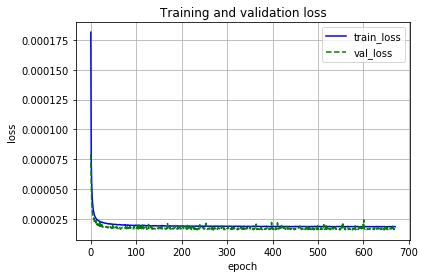

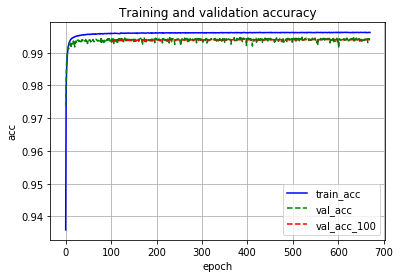

acc max step:582



Epoch [672/10000], Loss: 0.0000186835, val_loss: 0.0000177817, val_acc: 0.9938765216



Epoch [673/10000], Loss: 0.0000185248, val_loss: 0.0000163654, val_acc: 0.9940837657



Epoch [674/10000], Loss: 0.0000186655, val_loss: 0.0000164825, val_acc: 0.9943535742



Epoch [675/10000], Loss: 0.0000185259, val_loss: 0.0000157297, val_acc: 0.9945178054



Epoch [676/10000], Loss: 0.0000185115, val_loss: 0.0000159321, val_acc: 0.9943574844



Epoch [677/10000], Loss: 0.0000186769, val_loss: 0.0000166972, val_acc: 0.9938843421



Epoch [678/10000], Loss: 0.0000186334, val_loss: 0.0000173165, val_acc: 0.9937201109



Epoch [679/10000], Loss: 0.0000186739, val_loss: 0.0000168852, val_acc: 0.9939195345



Epoch [680/10000], Loss: 0.0000185122, val_loss: 0.0000161161, val_acc: 0.9941150479



Epoch [681/10000], Loss: 0.0000186071, val_loss: 0.0000171071, val_acc: 0.9938726113
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.67      0.90      0.77      1384
          ES       0.78      0.99      0.87      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



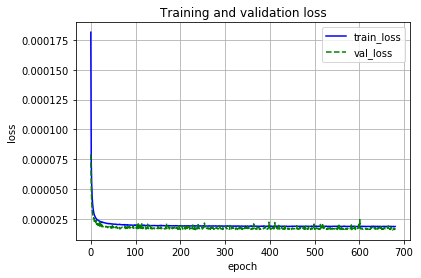

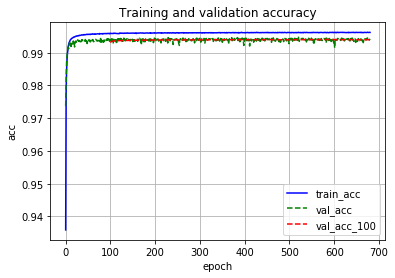

acc max step:582



Epoch [682/10000], Loss: 0.0000187350, val_loss: 0.0000166511, val_acc: 0.9943027407



Epoch [683/10000], Loss: 0.0000186237, val_loss: 0.0000168013, val_acc: 0.9943027407



Epoch [684/10000], Loss: 0.0000185624, val_loss: 0.0000167724, val_acc: 0.9941111376



Epoch [685/10000], Loss: 0.0000184560, val_loss: 0.0000163185, val_acc: 0.9942088943



Epoch [686/10000], Loss: 0.0000185567, val_loss: 0.0000163665, val_acc: 0.9942636380



Epoch [687/10000], Loss: 0.0000188444, val_loss: 0.0000162065, val_acc: 0.9941737019



Epoch [688/10000], Loss: 0.0000185284, val_loss: 0.0000162522, val_acc: 0.9942753688



Epoch [689/10000], Loss: 0.0000187376, val_loss: 0.0000180418, val_acc: 0.9934463922



Epoch [690/10000], Loss: 0.0000186153, val_loss: 0.0000183105, val_acc: 0.9941854327



Epoch [691/10000], Loss: 0.0000186684, val_loss: 0.0000181279, val_acc: 0.9935011359
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.65      0.91      0.76      1384
          ES       0.78      0.99      0.87      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.81      0.96      0.87     49859
weighted avg       0.98      0.98      0.98     49859



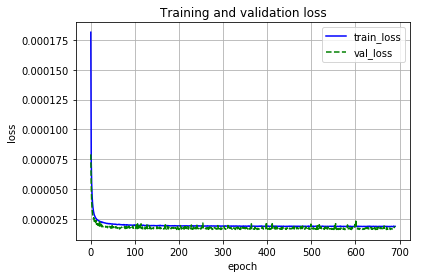

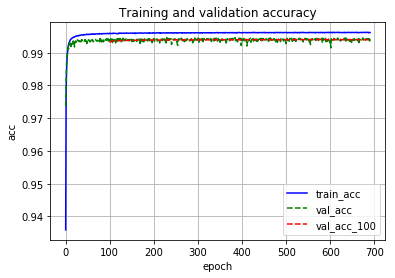

acc max step:582



Epoch [692/10000], Loss: 0.0000186266, val_loss: 0.0000163614, val_acc: 0.9941893430



Epoch [693/10000], Loss: 0.0000186255, val_loss: 0.0000170153, val_acc: 0.9945569081



Epoch [694/10000], Loss: 0.0000186394, val_loss: 0.0000159317, val_acc: 0.9941815224



Epoch [695/10000], Loss: 0.0000185494, val_loss: 0.0000161137, val_acc: 0.9941854327



Epoch [696/10000], Loss: 0.0000187323, val_loss: 0.0000165885, val_acc: 0.9942910099



Epoch [697/10000], Loss: 0.0000185551, val_loss: 0.0000159847, val_acc: 0.9944865233



Epoch [698/10000], Loss: 0.0000184533, val_loss: 0.0000162376, val_acc: 0.9943926769



Epoch [699/10000], Loss: 0.0000186252, val_loss: 0.0000170191, val_acc: 0.9940642144



Epoch [700/10000], Loss: 0.0000185608, val_loss: 0.0000161655, val_acc: 0.9942714586



Epoch [701/10000], Loss: 0.0000186621, val_loss: 0.0000162710, val_acc: 0.9942323559
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.71      0.89      0.79      1384
          ES       0.80      0.99      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



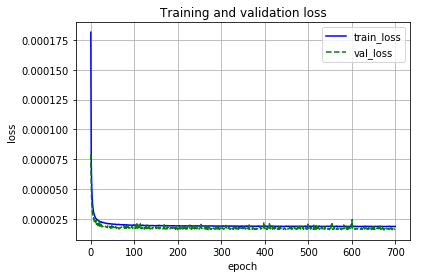

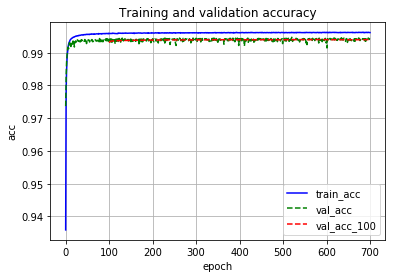

acc max step:582



Epoch [702/10000], Loss: 0.0000186575, val_loss: 0.0000166444, val_acc: 0.9944826130



Epoch [703/10000], Loss: 0.0000187401, val_loss: 0.0000183055, val_acc: 0.9935363283



Epoch [704/10000], Loss: 0.0000187629, val_loss: 0.0000166186, val_acc: 0.9942479970



Epoch [705/10000], Loss: 0.0000185185, val_loss: 0.0000166019, val_acc: 0.9940212015



Epoch [706/10000], Loss: 0.0000186286, val_loss: 0.0000168145, val_acc: 0.9939664577



Epoch [707/10000], Loss: 0.0000186886, val_loss: 0.0000171058, val_acc: 0.9940954965



Epoch [708/10000], Loss: 0.0000187906, val_loss: 0.0000167947, val_acc: 0.9943848563



Epoch [709/10000], Loss: 0.0000185741, val_loss: 0.0000166148, val_acc: 0.9941971635



Epoch [710/10000], Loss: 0.0000186533, val_loss: 0.0000177160, val_acc: 0.9942401764



Epoch [711/10000], Loss: 0.0000188582, val_loss: 0.0000175998, val_acc: 0.9937748546
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.63      0.91      0.75      1384
          ES       0.84      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



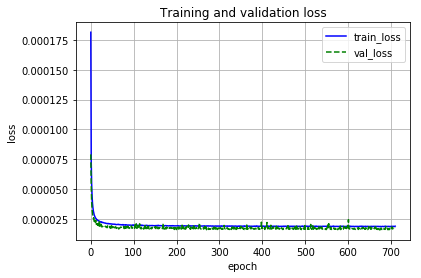

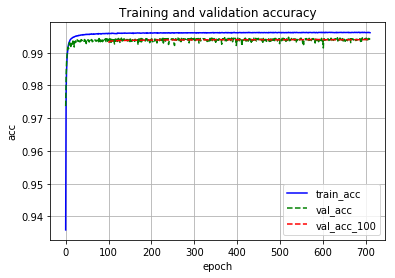

acc max step:710



Epoch [712/10000], Loss: 0.0000186808, val_loss: 0.0000164381, val_acc: 0.9943340228



Epoch [713/10000], Loss: 0.0000187361, val_loss: 0.0000172779, val_acc: 0.9937944060



Epoch [714/10000], Loss: 0.0000186321, val_loss: 0.0000166304, val_acc: 0.9941658814



Epoch [715/10000], Loss: 0.0000186621, val_loss: 0.0000168761, val_acc: 0.9938100470



Epoch [716/10000], Loss: 0.0000185992, val_loss: 0.0000173217, val_acc: 0.9945256259



Epoch [717/10000], Loss: 0.0000186146, val_loss: 0.0000164327, val_acc: 0.9940407528



Epoch [718/10000], Loss: 0.0000186837, val_loss: 0.0000160566, val_acc: 0.9942128046



Epoch [719/10000], Loss: 0.0000187008, val_loss: 0.0000180144, val_acc: 0.9934542127



Epoch [720/10000], Loss: 0.0000185322, val_loss: 0.0000184933, val_acc: 0.9933994690



Epoch [721/10000], Loss: 0.0000186942, val_loss: 0.0000183199, val_acc: 0.9941541506
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     47091
          BS       0.76      0.87      0.81      1384
          ES       0.85      0.98      0.91      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.87      0.95      0.91     49859
weighted avg       0.99      0.98      0.98     49859



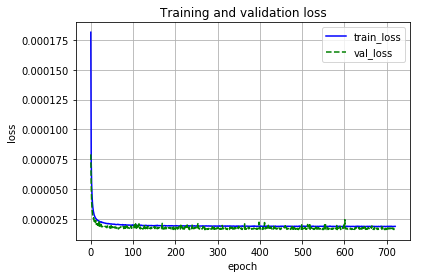

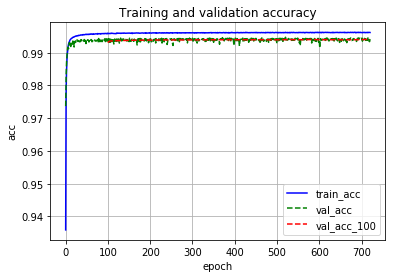

acc max step:716



Epoch [722/10000], Loss: 0.0000185611, val_loss: 0.0000165349, val_acc: 0.9940290220



Epoch [723/10000], Loss: 0.0000186962, val_loss: 0.0000163437, val_acc: 0.9940720349



Epoch [724/10000], Loss: 0.0000186263, val_loss: 0.0000171621, val_acc: 0.9941697916



Epoch [725/10000], Loss: 0.0000186002, val_loss: 0.0000192120, val_acc: 0.9930240833



Epoch [726/10000], Loss: 0.0000186310, val_loss: 0.0000183519, val_acc: 0.9932547891



Epoch [727/10000], Loss: 0.0000184897, val_loss: 0.0000163628, val_acc: 0.9942910099



Epoch [728/10000], Loss: 0.0000186629, val_loss: 0.0000203501, val_acc: 0.9927933776



Epoch [729/10000], Loss: 0.0000186345, val_loss: 0.0000166349, val_acc: 0.9942870996



Epoch [730/10000], Loss: 0.0000187451, val_loss: 0.0000161675, val_acc: 0.9942910099



Epoch [731/10000], Loss: 0.0000184354, val_loss: 0.0000163232, val_acc: 0.9942401764
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.72      0.90      0.80      1384
          ES       0.82      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



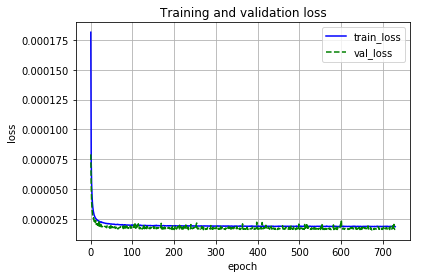

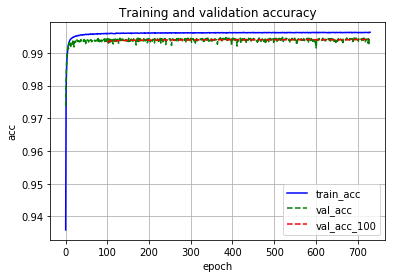

acc max step:716



Epoch [732/10000], Loss: 0.0000185716, val_loss: 0.0000162627, val_acc: 0.9940094707



Epoch [733/10000], Loss: 0.0000185056, val_loss: 0.0000168931, val_acc: 0.9939273551



Epoch [734/10000], Loss: 0.0000186616, val_loss: 0.0000160115, val_acc: 0.9943183818



Epoch [735/10000], Loss: 0.0000187287, val_loss: 0.0000175288, val_acc: 0.9939860091



Epoch [736/10000], Loss: 0.0000186144, val_loss: 0.0000168690, val_acc: 0.9938687010



Epoch [737/10000], Loss: 0.0000186055, val_loss: 0.0000192676, val_acc: 0.9932704302



Epoch [738/10000], Loss: 0.0000185307, val_loss: 0.0000168835, val_acc: 0.9943965871



Epoch [739/10000], Loss: 0.0000184797, val_loss: 0.0000165042, val_acc: 0.9943731255



Epoch [740/10000], Loss: 0.0000186785, val_loss: 0.0000164123, val_acc: 0.9940876760



Epoch [741/10000], Loss: 0.0000187041, val_loss: 0.0000166269, val_acc: 0.9940485733
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.68      0.91      0.78      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



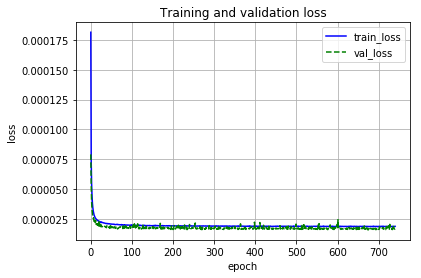

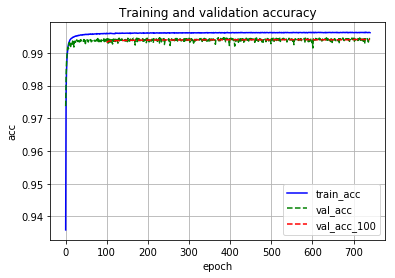

acc max step:716



Epoch [742/10000], Loss: 0.0000184769, val_loss: 0.0000181921, val_acc: 0.9934581230



Epoch [743/10000], Loss: 0.0000185826, val_loss: 0.0000159860, val_acc: 0.9943222920



Epoch [744/10000], Loss: 0.0000186549, val_loss: 0.0000164165, val_acc: 0.9941737019



Epoch [745/10000], Loss: 0.0000187282, val_loss: 0.0000163839, val_acc: 0.9942323559



Epoch [746/10000], Loss: 0.0000185620, val_loss: 0.0000172583, val_acc: 0.9940681247



Epoch [747/10000], Loss: 0.0000184476, val_loss: 0.0000158561, val_acc: 0.9944356898



Epoch [748/10000], Loss: 0.0000187514, val_loss: 0.0000177797, val_acc: 0.9934346614



Epoch [749/10000], Loss: 0.0000185417, val_loss: 0.0000176085, val_acc: 0.9935167770



Epoch [750/10000], Loss: 0.0000186328, val_loss: 0.0000171059, val_acc: 0.9939508167



Epoch [751/10000], Loss: 0.0000187511, val_loss: 0.0000166152, val_acc: 0.9943066510
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.71      0.90      0.79      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.85      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



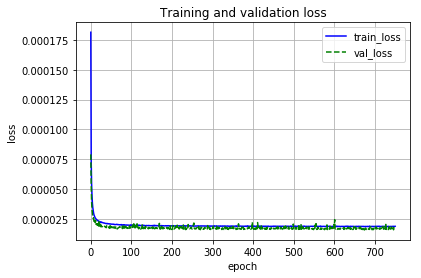

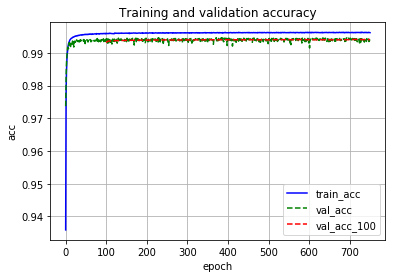

acc max step:716



Epoch [752/10000], Loss: 0.0000186378, val_loss: 0.0000163878, val_acc: 0.9939547269



Epoch [753/10000], Loss: 0.0000185236, val_loss: 0.0000179086, val_acc: 0.9941424198



Epoch [754/10000], Loss: 0.0000185651, val_loss: 0.0000169301, val_acc: 0.9945295362



Epoch [755/10000], Loss: 0.0000186603, val_loss: 0.0000167836, val_acc: 0.9940876760



Epoch [756/10000], Loss: 0.0000185862, val_loss: 0.0000171651, val_acc: 0.9937435725



Epoch [757/10000], Loss: 0.0000186806, val_loss: 0.0000166786, val_acc: 0.9940876760



Epoch [758/10000], Loss: 0.0000185797, val_loss: 0.0000164248, val_acc: 0.9942597278



Epoch [759/10000], Loss: 0.0000186480, val_loss: 0.0000178453, val_acc: 0.9935558797



Epoch [760/10000], Loss: 0.0000187551, val_loss: 0.0000190012, val_acc: 0.9931492119



Epoch [761/10000], Loss: 0.0000186366, val_loss: 0.0000170490, val_acc: 0.9937983162
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.69      0.91      0.79      1384
          ES       0.77      0.99      0.86      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



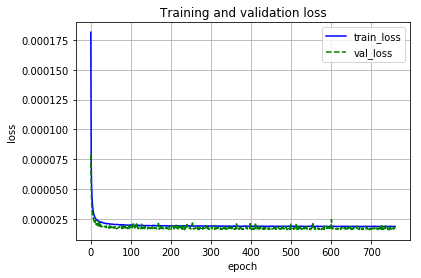

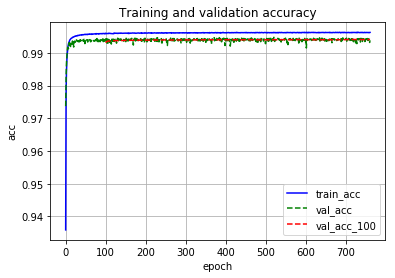

acc max step:716



Epoch [762/10000], Loss: 0.0000185942, val_loss: 0.0000174689, val_acc: 0.9935558797



Epoch [763/10000], Loss: 0.0000186581, val_loss: 0.0000167041, val_acc: 0.9940407528



Epoch [764/10000], Loss: 0.0000187026, val_loss: 0.0000161001, val_acc: 0.9941424198



Epoch [765/10000], Loss: 0.0000185767, val_loss: 0.0000181366, val_acc: 0.9934072895



Epoch [766/10000], Loss: 0.0000185687, val_loss: 0.0000163564, val_acc: 0.9940563939



Epoch [767/10000], Loss: 0.0000186596, val_loss: 0.0000181166, val_acc: 0.9935597899



Epoch [768/10000], Loss: 0.0000186951, val_loss: 0.0000164936, val_acc: 0.9938882524



Epoch [769/10000], Loss: 0.0000185930, val_loss: 0.0000178289, val_acc: 0.9943965871



Epoch [770/10000], Loss: 0.0000186019, val_loss: 0.0000159533, val_acc: 0.9944435103



Epoch [771/10000], Loss: 0.0000186531, val_loss: 0.0000174164, val_acc: 0.9940172912
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.68      0.91      0.78      1384
          ES       0.83      0.97      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



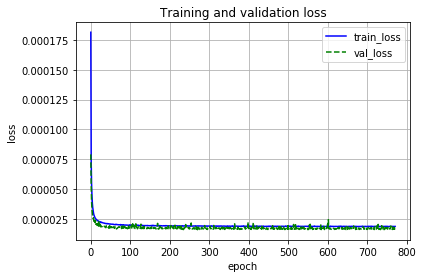

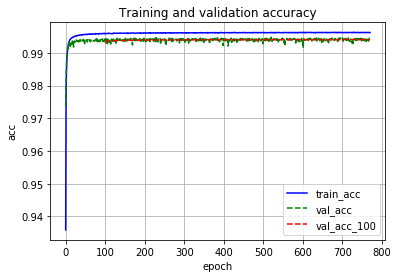

acc max step:716



Epoch [772/10000], Loss: 0.0000186084, val_loss: 0.0000164926, val_acc: 0.9942792791



Epoch [773/10000], Loss: 0.0000186683, val_loss: 0.0000163735, val_acc: 0.9942206251



Epoch [780/10000], Loss: 0.0000186502, val_loss: 0.0000167923, val_acc: 0.9941893430



Epoch [781/10000], Loss: 0.0000185772, val_loss: 0.0000163089, val_acc: 0.9945412670
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     47091
          BS       0.73      0.89      0.80      1384
          ES       0.85      0.98      0.91      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.86      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



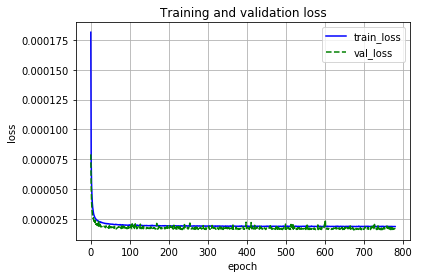

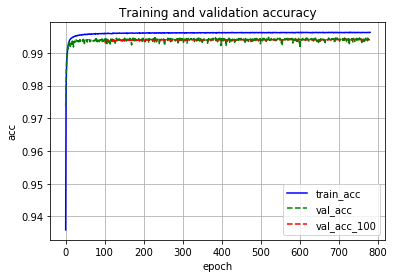

acc max step:716



Epoch [782/10000], Loss: 0.0000186500, val_loss: 0.0000163774, val_acc: 0.9942479970



Epoch [783/10000], Loss: 0.0000186836, val_loss: 0.0000173038, val_acc: 0.9938256881



Epoch [784/10000], Loss: 0.0000186214, val_loss: 0.0000164404, val_acc: 0.9940915863



Epoch [785/10000], Loss: 0.0000185863, val_loss: 0.0000183519, val_acc: 0.9943379331



Epoch [786/10000], Loss: 0.0000186242, val_loss: 0.0000172695, val_acc: 0.9940055604



Epoch [787/10000], Loss: 0.0000185298, val_loss: 0.0000167999, val_acc: 0.9942323559



Epoch [788/10000], Loss: 0.0000184480, val_loss: 0.0000162745, val_acc: 0.9942870996



Epoch [789/10000], Loss: 0.0000187125, val_loss: 0.0000170366, val_acc: 0.9937162006


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch [813/10000], Loss: 0.0000185056, val_loss: 0.0000164897, val_acc: 0.9942597278



Epoch [814/10000], Loss: 0.0000187406, val_loss: 0.0000171116, val_acc: 0.9940329323



Epoch [815/10000], Loss: 0.0000186416, val_loss: 0.0000171382, val_acc: 0.9939117140



Epoch [816/10000], Loss: 0.0000186142, val_loss: 0.0000161354, val_acc: 0.9942675483



Epoch [817/10000], Loss: 0.0000186813, val_loss: 0.0000181854, val_acc: 0.9934933154



Epoch [818/10000], Loss: 0.0000185484, val_loss: 0.0000166819, val_acc: 0.9942206251



Epoch [819/10000], Loss: 0.0000185994, val_loss: 0.0000166758, val_acc: 0.9943496639



Epoch [820/10000], Loss: 0.0000186041, val_loss: 0.0000157846, val_acc: 0.9944708822



Epoch [821/10000], Loss: 0.0000185939, val_loss: 0.0000164858, val_acc: 0.9942167148
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.69      0.90      0.78      1384
          ES       0.82      0.99      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



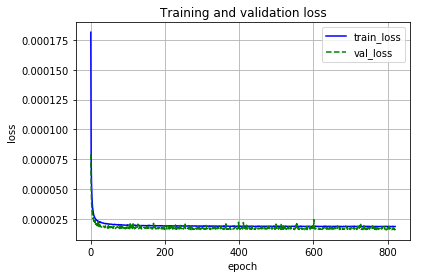

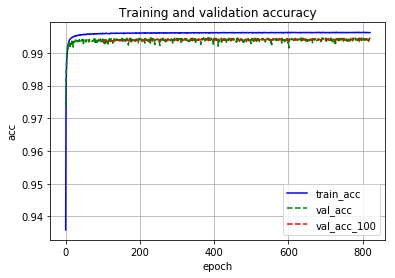

acc max step:716



Epoch [822/10000], Loss: 0.0000185765, val_loss: 0.0000164443, val_acc: 0.9941385095



Epoch [823/10000], Loss: 0.0000185781, val_loss: 0.0000172291, val_acc: 0.9937748546



Epoch [824/10000], Loss: 0.0000186668, val_loss: 0.0000169792, val_acc: 0.9938608805



Epoch [825/10000], Loss: 0.0000184419, val_loss: 0.0000169594, val_acc: 0.9945138951



Epoch [826/10000], Loss: 0.0000186431, val_loss: 0.0000193825, val_acc: 0.9939899193



Epoch [827/10000], Loss: 0.0000186382, val_loss: 0.0000171835, val_acc: 0.9939703680



Epoch [828/10000], Loss: 0.0000186212, val_loss: 0.0000166466, val_acc: 0.9939781885



Epoch [829/10000], Loss: 0.0000186339, val_loss: 0.0000160353, val_acc: 0.9944044077



Epoch [830/10000], Loss: 0.0000184872, val_loss: 0.0000184977, val_acc: 0.9939664577



Epoch [831/10000], Loss: 0.0000186546, val_loss: 0.0000168297, val_acc: 0.9943574844
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.72      0.90      0.80      1384
          ES       0.83      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.85      0.95      0.90     49859
weighted avg       0.98      0.98      0.98     49859



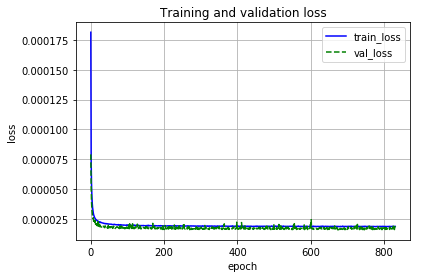

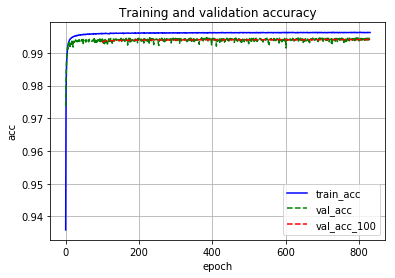

acc max step:716



Epoch [832/10000], Loss: 0.0000187211, val_loss: 0.0000174918, val_acc: 0.9937279314



Epoch [833/10000], Loss: 0.0000185469, val_loss: 0.0000158550, val_acc: 0.9944317795



Epoch [834/10000], Loss: 0.0000185623, val_loss: 0.0000166623, val_acc: 0.9940876760



Epoch [835/10000], Loss: 0.0000186433, val_loss: 0.0000194407, val_acc: 0.9928754932



Epoch [836/10000], Loss: 0.0000186009, val_loss: 0.0000164632, val_acc: 0.9940720349



Epoch [837/10000], Loss: 0.0000186744, val_loss: 0.0000165194, val_acc: 0.9942167148



Epoch [838/10000], Loss: 0.0000187361, val_loss: 0.0000173572, val_acc: 0.9936770980



Epoch [839/10000], Loss: 0.0000185484, val_loss: 0.0000175748, val_acc: 0.9936067131



Epoch [840/10000], Loss: 0.0000186695, val_loss: 0.0000213449, val_acc: 0.9923319660



Epoch [841/10000], Loss: 0.0000186335, val_loss: 0.0000163480, val_acc: 0.9941932532
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.72      0.89      0.80      1384
          ES       0.80      0.98      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.95      0.89     49859
weighted avg       0.98      0.98      0.98     49859



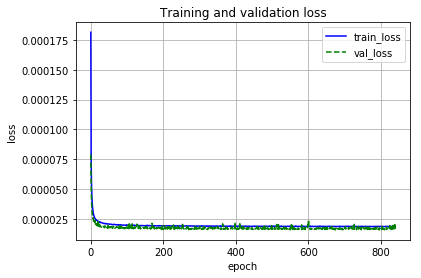

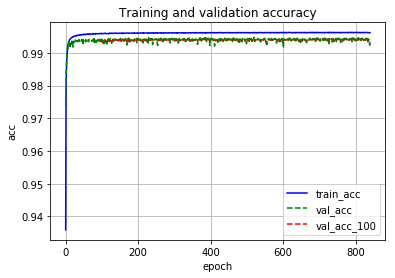

acc max step:716



Epoch [842/10000], Loss: 0.0000186391, val_loss: 0.0000170521, val_acc: 0.9939860091



Epoch [843/10000], Loss: 0.0000185875, val_loss: 0.0000176124, val_acc: 0.9936184439



Epoch [844/10000], Loss: 0.0000185873, val_loss: 0.0000169214, val_acc: 0.9939586372



Epoch [845/10000], Loss: 0.0000186307, val_loss: 0.0000183771, val_acc: 0.9932586994



Epoch [846/10000], Loss: 0.0000185338, val_loss: 0.0000166189, val_acc: 0.9940954965



Epoch [847/10000], Loss: 0.0000184884, val_loss: 0.0000168333, val_acc: 0.9940759452



Epoch [848/10000], Loss: 0.0000185013, val_loss: 0.0000170253, val_acc: 0.9944083179



Epoch [849/10000], Loss: 0.0000186021, val_loss: 0.0000164408, val_acc: 0.9943262023



Epoch [850/10000], Loss: 0.0000185622, val_loss: 0.0000159131, val_acc: 0.9943731255



Epoch [851/10000], Loss: 0.0000187067, val_loss: 0.0000164824, val_acc: 0.9941932532
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.70      0.90      0.79      1384
          ES       0.84      0.98      0.91      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



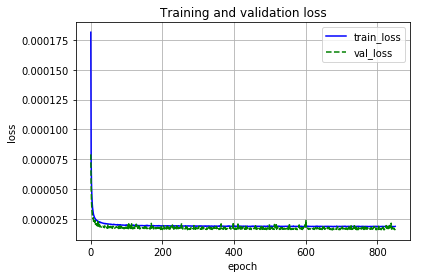

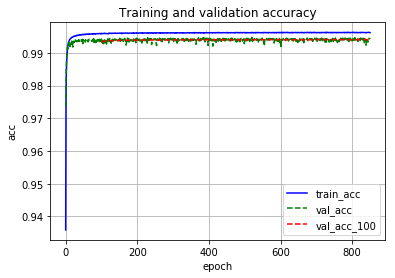

acc max step:716



Epoch [852/10000], Loss: 0.0000184495, val_loss: 0.0000172808, val_acc: 0.9937474828



Epoch [853/10000], Loss: 0.0000184694, val_loss: 0.0000178727, val_acc: 0.9941815224



Epoch [854/10000], Loss: 0.0000186092, val_loss: 0.0000179385, val_acc: 0.9939977399



Epoch [855/10000], Loss: 0.0000185222, val_loss: 0.0000166832, val_acc: 0.9941541506



Epoch [856/10000], Loss: 0.0000187768, val_loss: 0.0000166624, val_acc: 0.9940055604



Epoch [857/10000], Loss: 0.0000185065, val_loss: 0.0000207317, val_acc: 0.9926252361



Epoch [858/10000], Loss: 0.0000186031, val_loss: 0.0000166958, val_acc: 0.9940603041



Epoch [859/10000], Loss: 0.0000184955, val_loss: 0.0000179795, val_acc: 0.9933838279



Epoch [860/10000], Loss: 0.0000187485, val_loss: 0.0000166947, val_acc: 0.9941697916



Epoch [861/10000], Loss: 0.0000186802, val_loss: 0.0000163741, val_acc: 0.9940603041
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.68      0.91      0.78      1384
          ES       0.82      0.98      0.89      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



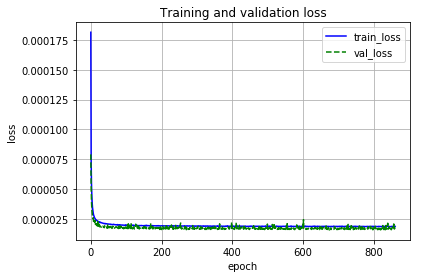

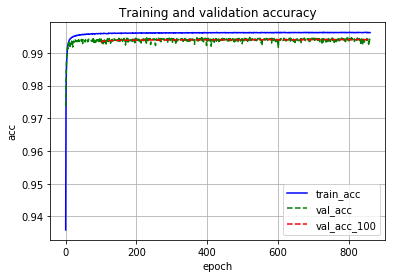

acc max step:716



Epoch [862/10000], Loss: 0.0000185275, val_loss: 0.0000165980, val_acc: 0.9941541506



Epoch [863/10000], Loss: 0.0000185226, val_loss: 0.0000174551, val_acc: 0.9937474828



Epoch [864/10000], Loss: 0.0000185797, val_loss: 0.0000170976, val_acc: 0.9939508167



Epoch [865/10000], Loss: 0.0000186350, val_loss: 0.0000163126, val_acc: 0.9943105612



Epoch [866/10000], Loss: 0.0000185699, val_loss: 0.0000163748, val_acc: 0.9944474206



Epoch [867/10000], Loss: 0.0000185749, val_loss: 0.0000160579, val_acc: 0.9942440867



Epoch [868/10000], Loss: 0.0000184874, val_loss: 0.0000164302, val_acc: 0.9942597278



Epoch [869/10000], Loss: 0.0000184740, val_loss: 0.0000206357, val_acc: 0.9927581852



Epoch [870/10000], Loss: 0.0000184907, val_loss: 0.0000189297, val_acc: 0.9932743404



Epoch [871/10000], Loss: 0.0000186339, val_loss: 0.0000171388, val_acc: 0.9940368425
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.68      0.91      0.78      1384
          ES       0.84      0.98      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.84      0.96      0.89     49859
weighted avg       0.98      0.98      0.98     49859



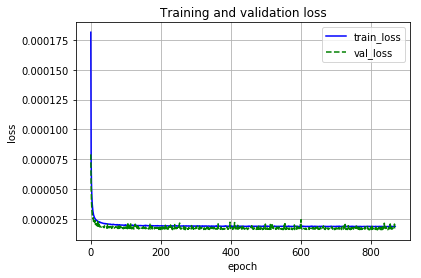

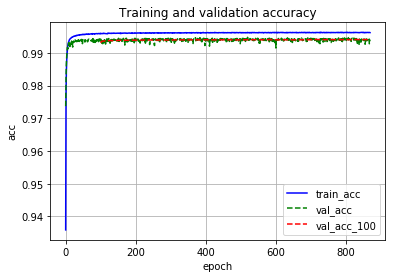

acc max step:716



Epoch [872/10000], Loss: 0.0000183437, val_loss: 0.0000164218, val_acc: 0.9942128046



Epoch [873/10000], Loss: 0.0000186482, val_loss: 0.0000164110, val_acc: 0.9941697916



Epoch [874/10000], Loss: 0.0000184963, val_loss: 0.0000164553, val_acc: 0.9938843421



Epoch [875/10000], Loss: 0.0000187599, val_loss: 0.0000162960, val_acc: 0.9942401764



Epoch [876/10000], Loss: 0.0000184551, val_loss: 0.0000184004, val_acc: 0.9933056226



Epoch [877/10000], Loss: 0.0000186785, val_loss: 0.0000191350, val_acc: 0.9930749168



Epoch [878/10000], Loss: 0.0000186434, val_loss: 0.0000161302, val_acc: 0.9944826130



Epoch [879/10000], Loss: 0.0000185330, val_loss: 0.0000165742, val_acc: 0.9944200487



Epoch [880/10000], Loss: 0.0000185957, val_loss: 0.0000169933, val_acc: 0.9938256881



Epoch [881/10000], Loss: 0.0000185312, val_loss: 0.0000171224, val_acc: 0.9938608805
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.67      0.90      0.77      1384
          ES       0.79      0.99      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.82      0.96      0.88     49859
weighted avg       0.98      0.98      0.98     49859



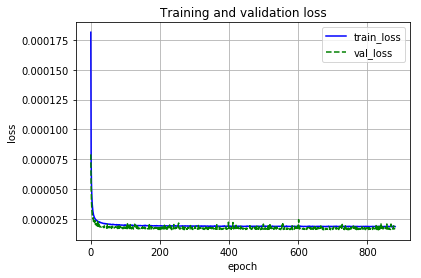

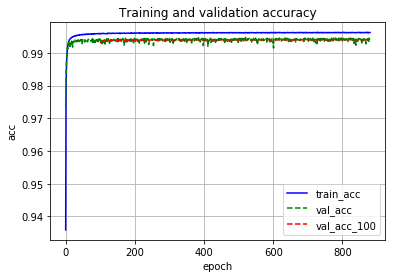

acc max step:716



Epoch [887/10000], Loss: 0.0000184967, val_loss: 0.0000166149, val_acc: 0.9943653050



Epoch [888/10000], Loss: 0.0000185622, val_loss: 0.0000168118, val_acc: 0.9941385095



Epoch [889/10000], Loss: 0.0000187046, val_loss: 0.0000161984, val_acc: 0.9944083179



Epoch [890/10000], Loss: 0.0000184118, val_loss: 0.0000168179, val_acc: 0.9938374189



Epoch [891/10000], Loss: 0.0000186009, val_loss: 0.0000168432, val_acc: 0.9939664577
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.70      0.89      0.79      1384
          ES       0.79      0.99      0.88      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.83      0.95      0.88     49859
weighted avg       0.98      0.98      0.98     49859



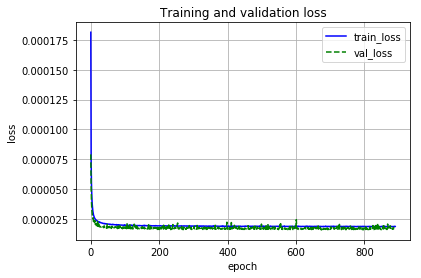

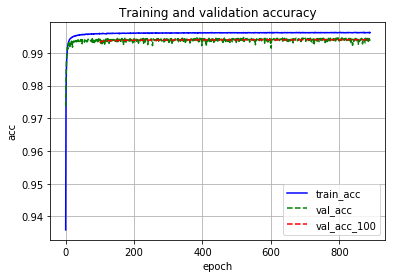

acc max step:716



Epoch [892/10000], Loss: 0.0000185523, val_loss: 0.0000169146, val_acc: 0.9942479970



Epoch [893/10000], Loss: 0.0000186189, val_loss: 0.0000169621, val_acc: 0.9939117140



Epoch [894/10000], Loss: 0.0000184553, val_loss: 0.0000174291, val_acc: 0.9935988926



Epoch [895/10000], Loss: 0.0000186623, val_loss: 0.0000165147, val_acc: 0.9941345992



Epoch [896/10000], Loss: 0.0000185701, val_loss: 0.0000160355, val_acc: 0.9941345992


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

num_epochs = 10000
digits = int(math.log10(num_epochs))+1

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
avg_val_acc_max = 0

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train==============================
    net.train()
    for i, (_input, _label) in enumerate(tqdm(train_loader)):
        _input, _label = _input.float().to(device), _label.to(device)
        optimizer.zero_grad()
        outputs = net(_input)
        loss = criterion(outputs, _label)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == _label).sum().item()
        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val==============================
    net.eval()
    with torch.no_grad():
        for i, (_input, _label) in enumerate(test_loader):        
            _input, _label = _input.float().to(device), _label.to(device)
            outputs = net(_input)
            loss = criterion(outputs, _label)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == _label).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.10f}, val_loss: {val_loss:.10f}, val_acc: {val_acc:.10f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    
    if avg_val_acc > avg_val_acc_max:
        ## save model
        avg_val_acc_max = avg_val_acc
        model_name = dir_name + "/v"+("0"*digits + str(epoch))[-digits:]+".pt"
        torch.save({
            'model': net.state_dict(),
        }, model_name)
        print("Saving the checkpoint...")
    if epoch % 10 == 0 and epoch != 0:
        result = net(inputs_dev).argmax(1)
        dev2 = {}
        dev2["text"] = dev["text"]
        dev2["begin_sentence"] = []
        dev2["end_sentence"] = []
        for i, _label in enumerate(result):
            if _label == 1:
                dev2["begin_sentence"].append(i)
            elif _label == 2:
                dev2["end_sentence"].append(i)
        evalfun.evaluate_result(dev,dev2)
        import matplotlib.pyplot as plt
        %matplotlib inline

        plt.figure()
        plt.plot(range(len(train_loss_list)), train_loss_list, color='blue', linestyle='-', label='train_loss')
        plt.plot(range(len(val_loss_list)), val_loss_list, color='green', linestyle='--', label='val_loss')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Training and validation loss')
        plt.grid()

        plt.figure()
        plt.plot(range(len(train_acc_list)), train_acc_list, color='blue', linestyle='-', label='train_acc')
        plt.plot(range(len(val_acc_list)), val_acc_list, color='green', linestyle='--', label='val_acc')
        num_ave = 100
        run_ave = np.array([0.0 for i in range(len(val_acc_list)-num_ave)])
        if len(val_acc_list) >= num_ave:
            for i in range(num_ave):
                run_ave  += np.array(val_acc_list[i:len(val_acc_list)-num_ave+i])
            run_ave /= num_ave
            plt.plot(range(num_ave, len(val_acc_list)), run_ave, color='red', linestyle='--', label='val_acc_'+str(num_ave))
            max_step = run_ave.argmax()+num_ave
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('acc')
        plt.title('Training and validation accuracy')
        plt.grid()
        plt.show()
        if len(val_acc_list) >= num_ave:
            print("acc max step:"+str(max_step))
            if len(val_acc_list) > max(max_step * 1.1 , max_step + num_ave * 2):
                break

acc max step:716


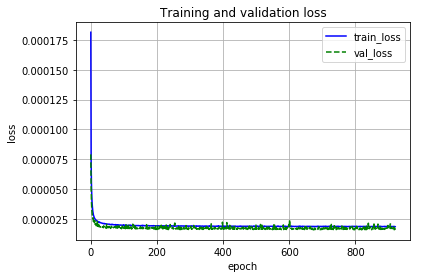

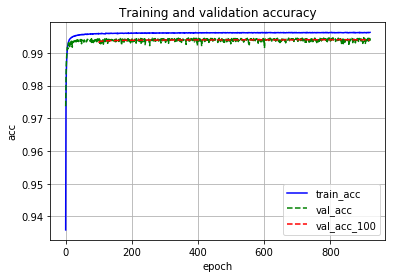

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(len(train_loss_list)), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(len(val_loss_list)), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(len(train_acc_list)), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(len(val_acc_list)), val_acc_list, color='green', linestyle='--', label='val_acc')
num_ave = 100
run_ave = np.array([0.0 for i in range(len(val_acc_list)-num_ave)])
for i in range(num_ave):
    run_ave  += np.array(val_acc_list[i:len(val_acc_list)-num_ave+i])
run_ave /= num_ave
plt.plot(range(num_ave, len(val_acc_list)), run_ave, color='red', linestyle='--', label='val_acc_'+str(num_ave))
max_step = run_ave.argmax()+num_ave
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
print("acc max step:"+str(max_step))

In [ ]:
result = net(torch.tensor(inputs_dev).float().to(device)).argmax(1)

In [30]:
dev2 = {}
dev2["text"] = dev["text"]
dev2["begin_sentence"] = []
dev2["end_sentence"] = []
for i, _label in enumerate(result):
    if _label == 1:
        dev2["begin_sentence"].append(i)
    elif _label == 2:
        dev2["end_sentence"].append(i)

In [31]:
evalfun.evaluate_result(dev,dev2)
a

              precision    recall  f1-score   support

           O       1.00      0.98      0.99     47091
          BS       0.71      0.90      0.80      1384
          ES       0.83      0.99      0.90      1384

   micro avg       0.98      0.98      0.98     49859
   macro avg       0.85      0.96      0.90     49859
weighted avg       0.98      0.98      0.98     49859



1302